# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor
import numpy as np

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f1cf7e67048>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../../input_files/ap2_repeat.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()
vec_rn = VectorizedRxnNet(rn, dev='cpu')

['default_assoc', 1.0]
['A']
['B']
['S']
Parsing rule...
['A(a)+A(b)<->A(a!1).A(a!1)', '', 'G=-20']
['A', 'A', '']
['A(a)+A(b)', 'A(a!1).A(a!1)']
GGGGGGGGGgg
Parsing rule...
['A(c)+S(a)<->A(c!1).S(a!1)', '', 'G=-20']
['A', 'S', '']
['A(c)+S(a)', 'A(c!1).S(a!1)']
GGGGGGGGGgg
Parsing rule...
['B(b)+A(b)<->B(b!1).A(b!1)', '', 'G=-20']
['B', 'A', '']
['B(b)+A(b)', 'B(b!1).A(b!1)']
GGGGGGGGGgg
Parsing rule...
['B(c)+S(b)<->B(c!1).S(b!1)', '', 'G=-20']
['B', 'S', '']
['B(c)+S(b)', 'B(c!1).S(b!1)']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7f1c62089f28>, 'copies': tensor([300.], dtype=torch.float64)})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7f1c62089f28>, 'copies': tensor([300.], dtype=torch.float64)})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7f1c62089f28>, 'copies': tensor([300.], dtype=torch.float64)})
Node-2 :  (1, {'struct': <networkx.classes.graph.Gr

('A', 'A')
Allowed edges: 
('A', 'S')
############################3
Repeat Units
Allowed edges: 
('A', 'B')
Allowed edges: 
('B', 'S')
############################3
Repeat Units
[(10, {'struct': <networkx.classes.graph.Graph object at 0x7f1c61b30dd8>, 'copies': tensor([0.], dtype=torch.float64)})]
Node-1 :  (8, {'struct': <networkx.classes.graph.Graph object at 0x7f1c62229eb8>, 'copies': tensor([0.], dtype=torch.float64)})
Node-2 :  (3, {'struct': <networkx.classes.graph.Graph object at 0x7f1c620931d0>, 'copies': tensor([0.], dtype=torch.float64)})
-----
{'A', 'B'}
{'A', 'B'}
set()
Steric hindrance detected
Node-1 :  (8, {'struct': <networkx.classes.graph.Graph object at 0x7f1c62229eb8>, 'copies': tensor([0.], dtype=torch.float64)})
Node-2 :  (4, {'struct': <networkx.classes.graph.Graph object at 0x7f1c628d6240>, 'copies': tensor([0.], dtype=torch.float64)})
-----
{'A', 'B'}
{'A', 'S'}
{'B'}
Steric hindrance detected
Node-1 :  (8, {'struct': <networkx.classes.graph.Graph object at 0x7f

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n)
    print(gtostr(rn.network.nodes()[n]['struct']))
    for k,v in rn.network[n].items():
        print(v)
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

0
A
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 9}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 10}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-80.], dtype=torch.float64), 'uid': 11}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 12}
1
B
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}

A -- 0
[]
B -- 1
[]
S -- 2
[]
AB -- 3
[('A', 'B')]
AS -- 4
[('A', 'S')]
AA -- 5
[('A', 'A')]
BS -- 6
[('B', 'S')]
ABS -- 7
[('B', 'A'), ('B', 'S'), ('A', 'S')]
ABA -- 8
[('B', 'A'), ('A', 'A')]
ASA -- 9
[('S', 'A'), ('A', 'A')]
ABSA -- 10
[('S', 'A'), ('S', 'B'), ('B', 'A'), ('A', 'A')]
{3: {'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}, 6: {'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}, 7: {'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}, 8: {'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 5}, 10: {'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-80.], dtype=torch.float64), 'uid': 14}}


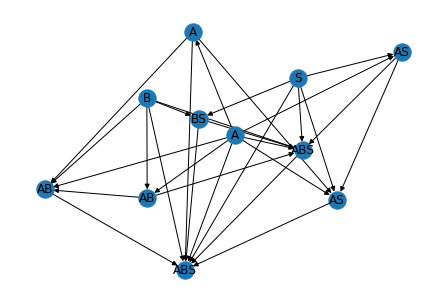

In [5]:
import networkx as nx
labels = nx.get_node_attributes(rn.network, 'struct')
labels = {key:gtostr(labels[key]) for key in labels.keys()}
nx.draw(rn.network, labels=labels)

for node in rn.network.nodes(data=True):
    st = gtostr(node[1]['struct'])
    new_st = []
    n_edges = node[1]['struct'].number_of_edges()
#     st1 = [set(i) for i in node[1]['struct'].edges()]
#     a=[]
#     for i in st1:
#         a+=list(i) 
    
    if n_edges >= len(set(st)):
        for u,v in node[1]['struct'].edges():
            if u==v:
                st=st+u
                
    print(st,"--",node[0])
#     print("".join(a), "--",node[0])
    print(node[1]['struct'].edges())
    
print(rn.network[1]) 

In [6]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 3): 0, (0, 4): 1, (0, 5): 2, (0, 8): 9, (0, 9): 10, (0, 10): 11, (0, 7): 12, (1, 3): 0, (1, 6): 3, (1, 7): 4, (1, 8): 5, (1, 10): 14, (2, 4): 1, (2, 6): 3, (2, 7): 6, (2, 9): 7, (2, 10): 8, (3, 7): 6, (3, 8): 9, (4, 7): 4, (4, 9): 10, (5, 8): 5, (5, 9): 7, (5, 10): 11, (6, 10): 11, (6, 7): 12, (7, 10): 13, (8, 10): 8, (9, 10): 14}


In [7]:
#Do modifications here
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
new_kon = new_kon + Tensor([1.]*np.array(1e0))
update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

# for edge in rn.network.edges:
#     print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.kon)

#Changing initial concentrations

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 9}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 10}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-80.], dtype=torch.float64), 'uid': 11}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 12}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}
{'k_on'

## The Equilibrium Solution ##
First we will find the equilibrium solution for this system.

In [8]:
vec_rn.update_reaction_net(rn)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve()
print(solution)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

IndexError: tuple index out of range

In [ ]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        if len(edges)==0:
            return(False)
        kon_max = -1
        next_node = -1
        
        kon_sum = 0
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']
            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (self._R * self._T)) + l_kon + torch.log(std_c)
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

pathway = []
kon_sumarray = []
total_con_rate = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]

print(pathway)
print(kon_sumarray)
#print(total_con_rate)

In [ ]:
if solution != None:
    for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
        print(k," : ", v.item())

In [ ]:
# if solution !=None:
#     for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#         print(k," : ", v)

## Using the optimizer with a 1 second simulation runtime ##

In [9]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=5000,
                  learning_rate=.01,
                  device='cpu')
optim.rn.update_reaction_net(rn)
optim.optimize()

Using CPU
Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64, requires_grad=True)]
Using CPU
Next time:  tensor(2.3837, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 0 was 41.8%
current params: tensor([0.9900, 0.9900, 1.0100, 1.0100, 1.0100, 0.9900, 1.0100, 0.9900, 1.0100,
        1.0100, 1.0100, 1.0100, 0.9900, 1.0100, 1.0100], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2839, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1 was 42.2%
current params: tensor([0.9800, 0.9800, 1.0200, 1.0200, 1.0199, 0.9800, 1.0199, 0.9800, 1.0200,
        1.0200, 1.0200, 1.0200, 0.9800, 1.0193, 1.0200], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0145, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than

Next time:  tensor(1.0170, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 23 was 53.0%
current params: tensor([0.7557, 0.7557, 1.2379, 1.2388, 1.1808, 0.7538, 1.1811, 0.7539, 1.2381,
        1.2346, 1.2346, 1.2418, 0.7545, 1.1623, 1.2380], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0232, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 24 was 53.6%
current params: tensor([0.7451, 0.7452, 1.2476, 1.2487, 1.1822, 0.7431, 1.1825, 0.7432, 1.2478,
        1.2440, 1.2439, 1.2521, 0.7438, 1.1654, 1.2477], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0330, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 25 was 54.1%
current params: tensor([0.7346, 0.7346, 1.2573, 1.2585, 1.1829, 0.7323, 1.1831, 0.7323, 1.2575,
        1.2532, 1.2532, 1.262

Next time:  tensor(6.2195, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 47 was 67.2%
current params: tensor([0.4895, 0.4895, 1.4641, 1.4697, 1.0365, 0.4761, 1.0282, 0.4754, 1.4638,
        1.4446, 1.4449, 1.4876, 0.4840, 1.1953, 1.4616], dtype=torch.float64)
Using CPU
Next time:  tensor(6.2564, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 48 was 67.9%
current params: tensor([0.4776, 0.4775, 1.4731, 1.4789, 1.0265, 0.4637, 1.0163, 0.4628, 1.4725,
        1.4527, 1.4530, 1.4975, 0.4719, 1.1969, 1.4706], dtype=torch.float64)
Using CPU
Next time:  tensor(6.2947, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 49 was 68.6%
current params: tensor([0.4656, 0.4656, 1.4820, 1.4882, 1.0161, 0.4512, 1.0042, 0.4501, 1.4813,
        1.4607, 1.4610, 1.507

Next time:  tensor(1.2045, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 71 was 86.9%
current params: tensor([0.1878, 0.1862, 1.6604, 1.6760, 0.7531, 0.1560, 0.7086, 0.1491, 1.6551,
        1.6169, 1.6174, 1.6892, 0.1734, 1.2327, 1.6592], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5967, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 72 was 87.9%
current params: tensor([0.1746, 0.1728, 1.6675, 1.6836, 0.7402, 0.1413, 0.6950, 0.1342, 1.6619,
        1.6228, 1.6232, 1.6957, 0.1594, 1.2334, 1.6660], dtype=torch.float64)
Using CPU
Next time:  tensor(1.8177, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 73 was 88.9%
current params: tensor([0.1613, 0.1595, 1.6745, 1.6911, 0.7274, 0.1265, 0.6814, 0.1192, 1.6684,
        1.6286, 1.6289, 1.702

Next time:  tensor(1.4689, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 95 was 89.4%
current params: tensor([0.1531, 0.1504, 1.8064, 1.8396, 0.4714, 0.1474, 0.4253, 0.1834, 1.7849,
        1.7238, 1.7222, 1.8078, 0.1909, 1.2791, 1.7884], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4525, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 96 was 89.4%
current params: tensor([0.1536, 0.1510, 1.8122, 1.8461, 0.4596, 0.1470, 0.4148, 0.1841, 1.7900,
        1.7276, 1.7259, 1.8126, 0.1926, 1.2804, 1.7935], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4385, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 97 was 89.4%
current params: tensor([0.1539, 0.1514, 1.8180, 1.8526, 0.4476, 0.1464, 0.4044, 0.1848, 1.7950,
        1.7315, 1.7296, 1.817

Next time:  tensor(1.4161, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 119 was 91.0%
current params: tensor([0.1407, 0.1417, 1.9480, 1.9931, 0.1684, 0.1156, 0.1844, 0.1768, 1.9051,
        1.8170, 1.8103, 1.9262, 0.1996, 1.2767, 1.9094], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4230, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 120 was 91.1%
current params: tensor([0.1396, 0.1409, 1.9539, 1.9993, 0.1550, 0.1137, 0.1750, 0.1760, 1.9099,
        1.8208, 1.8138, 1.9311, 0.1992, 1.2756, 1.9143], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4305, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 121 was 91.2%
current params: tensor([0.1385, 0.1401, 1.9599, 2.0056, 0.1416, 0.1117, 0.1657, 0.1752, 1.9147,
        1.8246, 1.8174, 1.

Next time:  tensor(1.4604, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 143 was 92.0%
current params: tensor([0.1130, 0.1209, 2.0902, 2.1428, 0.2231, 0.1420, 0.1806, 0.1546, 2.0151,
        1.9043, 1.8911, 2.0394, 0.1883, 1.2809, 2.0207], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4667, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 144 was 92.0%
current params: tensor([0.1118, 0.1200, 2.0961, 2.1492, 0.2256, 0.1422, 0.1832, 0.1535, 2.0196,
        1.9077, 1.8943, 2.0438, 0.1877, 1.2874, 2.0253], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4738, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 145 was 92.1%
current params: tensor([0.1106, 0.1190, 2.1020, 2.1556, 0.2280, 0.1422, 0.1856, 0.1524, 2.0241,
        1.9110, 1.8976, 2.

Next time:  tensor(1.5415, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 167 was 92.7%
current params: tensor([0.1534, 0.1279, 2.2322, 2.2997, 0.2471, 0.1247, 0.2050, 0.1261, 2.1202,
        1.9798, 1.9650, 2.1407, 0.1743, 1.4718, 2.1244], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5362, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 168 was 92.6%
current params: tensor([0.1552, 0.1331, 2.2382, 2.3063, 0.2473, 0.1236, 0.2052, 0.1248, 2.1244,
        1.9832, 1.9679, 2.1448, 0.1737, 1.4782, 2.1285], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5344, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 169 was 92.6%
current params: tensor([0.1567, 0.1377, 2.2441, 2.3130, 0.2475, 0.1224, 0.2053, 0.1235, 2.1286,
        1.9867, 1.9709, 2.

Next time:  tensor(1.5215, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 191 was 92.8%
current params: tensor([0.1596, 0.1655, 2.3788, 2.4635, 0.2485, 0.1222, 0.2060, 0.1264, 2.2164,
        2.0690, 2.0486, 2.2326, 0.1600, 1.5377, 2.2196], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4765, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 192 was 92.7%
current params: tensor([0.1590, 0.1652, 2.3851, 2.4705, 0.2485, 0.1263, 0.2059, 0.1300, 2.2202,
        2.0729, 2.0524, 2.2363, 0.1594, 1.5386, 2.2234], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4411, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 193 was 92.6%
current params: tensor([0.1585, 0.1649, 2.3913, 2.4775, 0.2485, 0.1299, 0.2059, 0.1331, 2.2241,
        2.0767, 2.0563, 2.

Next time:  tensor(1.3201, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 215 was 92.8%
current params: tensor([0.1433, 0.1520, 2.5283, 2.6371, 0.2479, 0.1442, 0.2050, 0.1442, 2.3154,
        2.1563, 2.1384, 2.3217, 0.1454, 1.5414, 2.3170], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3247, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 216 was 92.9%
current params: tensor([0.1426, 0.1513, 2.5345, 2.6445, 0.2478, 0.1435, 0.2050, 0.1435, 2.3197,
        2.1597, 2.1420, 2.3254, 0.1448, 1.5412, 2.3211], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3298, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 217 was 92.9%
current params: tensor([0.1418, 0.1505, 2.5407, 2.6520, 0.2478, 0.1428, 0.2049, 0.1428, 2.3239,
        2.1631, 2.1455, 2.

Next time:  tensor(1.5617, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 239 was 94.1%
current params: tensor([0.1247, 0.1338, 2.6773, 2.8167, 0.2471, 0.1210, 0.2041, 0.1216, 2.4138,
        2.2353, 2.2208, 2.4031, 0.1301, 1.6591, 2.4118], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5793, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 240 was 94.2%
current params: tensor([0.1240, 0.1331, 2.6835, 2.8242, 0.2471, 0.1199, 0.2040, 0.1206, 2.4177,
        2.2384, 2.2240, 2.4063, 0.1294, 1.6643, 2.4154], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5977, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 241 was 94.2%
current params: tensor([0.1232, 0.1323, 2.6897, 2.8317, 0.2471, 0.1187, 0.2040, 0.1195, 2.4215,
        2.2415, 2.2271, 2.

Next time:  tensor(1.5950, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 263 was 94.7%
current params: tensor([0.1065, 0.1163, 2.8258, 2.9970, 0.2464, 0.1309, 0.2032, 0.1239, 2.5013,
        2.3036, 2.2890, 2.4783, 0.1142, 1.6760, 2.4910], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5409, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 264 was 94.6%
current params: tensor([0.1057, 0.1156, 2.8320, 3.0046, 0.2463, 0.1342, 0.2032, 0.1282, 2.5045,
        2.3060, 2.2917, 2.4813, 0.1135, 1.6735, 2.4943], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4983, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 265 was 94.6%
current params: tensor([0.1050, 0.1148, 2.8381, 3.0122, 0.2463, 0.1371, 0.2032, 0.1320, 2.5077,
        2.3084, 2.2945, 2.

Next time:  tensor(1.2840, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 287 was 93.9%
current params: tensor([0.1650, 0.1164, 2.9745, 3.1847, 0.2458, 0.1490, 0.2023, 0.1494, 2.5826,
        2.3604, 2.3502, 2.5416, 0.1246, 1.6403, 2.5801], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2830, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 288 was 93.8%
current params: tensor([0.1666, 0.1237, 2.9808, 3.1927, 0.2458, 0.1484, 0.2023, 0.1488, 2.5863,
        2.3633, 2.3525, 2.5440, 0.1312, 1.6422, 2.5839], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2831, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 289 was 93.7%
current params: tensor([0.1681, 0.1301, 2.9871, 3.2007, 0.2458, 0.1479, 0.2022, 0.1482, 2.5900,
        2.3663, 2.3549, 2.

Next time:  tensor(1.4528, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 311 was 93.6%
current params: tensor([0.1718, 0.1749, 3.1315, 3.3769, 0.2453, 0.1300, 0.2013, 0.1284, 2.6725,
        2.4378, 2.4184, 2.6143, 0.1786, 1.6905, 2.6715], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4660, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 312 was 93.7%
current params: tensor([0.1714, 0.1750, 3.1383, 3.3849, 0.2452, 0.1291, 0.2012, 0.1274, 2.6761,
        2.4411, 2.4217, 2.6178, 0.1787, 1.6911, 2.6752], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4798, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 313 was 93.7%
current params: tensor([0.1710, 0.1750, 3.1450, 3.3929, 0.2452, 0.1281, 0.2012, 0.1264, 2.6797,
        2.4444, 2.4250, 2.

Next time:  tensor(2.0890, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 335 was 94.6%
current params: tensor([0.1601, 0.1669, 3.2953, 3.5678, 0.2446, 0.1057, 0.2002, 0.1025, 2.7540,
        2.5130, 2.4985, 2.7050, 0.1716, 1.6675, 2.7571], dtype=torch.float64)
Using CPU
Next time:  tensor(2.1462, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 336 was 94.7%
current params: tensor([0.1595, 0.1664, 3.3022, 3.5757, 0.2446, 0.1046, 0.2001, 0.1014, 2.7571,
        2.5159, 2.5017, 2.7095, 0.1711, 1.6605, 2.7604], dtype=torch.float64)
Using CPU
Next time:  tensor(2.2087, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 337 was 94.7%
current params: tensor([0.1590, 0.1658, 3.3090, 3.5836, 0.2445, 0.1035, 0.2001, 0.1002, 2.7601,
        2.5187, 2.5049, 2.

Next time:  tensor(1.2576, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 359 was 94.0%
current params: tensor([0.1468, 0.1541, 3.4601, 3.7601, 0.2439, 0.1521, 0.1992, 0.1535, 2.8319,
        2.5803, 2.5693, 2.8049, 0.1594, 1.5185, 2.8354], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2553, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 360 was 94.0%
current params: tensor([0.1462, 0.1536, 3.4669, 3.7683, 0.2439, 0.1524, 0.1992, 0.1536, 2.8355,
        2.5831, 2.5721, 2.8085, 0.1588, 1.5182, 2.8388], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2540, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 361 was 94.0%
current params: tensor([0.1456, 0.1530, 3.4738, 3.7765, 0.2438, 0.1526, 0.1991, 0.1535, 2.8391,
        2.5859, 2.5749, 2.

Next time:  tensor(1.3655, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 383 was 94.7%
current params: tensor([0.1325, 0.1405, 3.6245, 3.9589, 0.2432, 0.1420, 0.1985, 0.1416, 2.9188,
        2.6471, 2.6363, 2.8780, 0.1461, 1.6674, 2.9167], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3754, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 384 was 94.7%
current params: tensor([0.1319, 0.1399, 3.6313, 3.9673, 0.2432, 0.1412, 0.1984, 0.1408, 2.9223,
        2.6497, 2.6389, 2.8807, 0.1455, 1.6742, 2.9200], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3858, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 385 was 94.7%
current params: tensor([0.1314, 0.1393, 3.6382, 3.9756, 0.2432, 0.1404, 0.1984, 0.1401, 2.9259,
        2.6523, 2.6416, 2.

Next time:  tensor(1.7167, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 407 was 95.5%
current params: tensor([0.1183, 0.1276, 3.7886, 4.1597, 0.2426, 0.1197, 0.1979, 0.1223, 3.0038,
        2.7079, 2.6919, 2.9456, 0.1326, 1.7333, 2.9872], dtype=torch.float64)
Using CPU
Next time:  tensor(1.7392, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 408 was 95.5%
current params: tensor([0.1177, 0.1271, 3.7955, 4.1681, 0.2426, 0.1187, 0.1979, 0.1215, 3.0075,
        2.7104, 2.6938, 2.9483, 0.1320, 1.7343, 2.9896], dtype=torch.float64)
Using CPU
Next time:  tensor(1.7626, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 409 was 95.5%
current params: tensor([0.1171, 0.1266, 3.8023, 4.1764, 0.2425, 0.1176, 0.1978, 0.1208, 3.0111,
        2.7130, 2.6958, 2.

Next time:  tensor(2.6475, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 431 was 96.0%
current params: tensor([0.1042, 0.1157, 3.9529, 4.3614, 0.2420, 0.1297, 0.1974, 0.1027, 3.0807,
        2.7633, 2.7391, 3.0058, 0.1189, 1.7540, 3.0455], dtype=torch.float64)
Using CPU
Next time:  tensor(2.6667, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 432 was 96.0%
current params: tensor([0.1036, 0.1152, 3.9598, 4.3698, 0.2419, 0.1339, 0.1974, 0.1018, 3.0834,
        2.7652, 2.7411, 3.0081, 0.1184, 1.7546, 3.0481], dtype=torch.float64)
Using CPU
Next time:  tensor(2.6811, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 433 was 95.9%
current params: tensor([0.1031, 0.1146, 3.9666, 4.3782, 0.2419, 0.1376, 0.1974, 0.1009, 3.0861,
        2.7672, 2.7432, 3.

Next time:  tensor(1.1558, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 455 was 95.0%
current params: tensor([0.1771, 0.1013, 4.1181, 4.5666, 0.2416, 0.1584, 0.1967, 0.1571, 3.1453,
        2.8079, 2.7891, 3.0616, 0.1050, 1.8463, 3.1187], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1538, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 456 was 95.0%
current params: tensor([0.1789, 0.1007, 4.1250, 4.5753, 0.2416, 0.1582, 0.1966, 0.1571, 3.1480,
        2.8101, 2.7912, 3.0632, 0.1044, 1.8486, 3.1223], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1525, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 457 was 95.0%
current params: tensor([0.1805, 0.1000, 4.1320, 4.5841, 0.2416, 0.1580, 0.1966, 0.1570, 3.1507,
        2.8123, 2.7933, 3.

Next time:  tensor(1.4030, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 479 was 94.4%
current params: tensor([0.1874, 0.1845, 4.2876, 4.7772, 0.2413, 0.1461, 0.1956, 0.1437, 3.2167,
        2.8710, 2.8441, 3.1027, 0.1790, 1.9072, 3.2038], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4203, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 480 was 94.5%
current params: tensor([0.1871, 0.1852, 4.2948, 4.7859, 0.2413, 0.1454, 0.1956, 0.1429, 3.2198,
        2.8737, 2.8467, 3.1053, 0.1808, 1.9081, 3.2073], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4379, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 481 was 94.5%
current params: tensor([0.1869, 0.1858, 4.3021, 4.7946, 0.2413, 0.1447, 0.1956, 0.1421, 3.2229,
        2.8765, 2.8494, 3.

Next time:  tensor(2.1074, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 503 was 94.9%
current params: tensor([0.1790, 0.1845, 4.4638, 4.9863, 0.2408, 0.1273, 0.1947, 0.1229, 3.2888,
        2.9345, 2.9118, 3.1737, 0.1889, 1.9210, 3.2832], dtype=torch.float64)
Using CPU
Next time:  tensor(2.1669, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 504 was 95.0%
current params: tensor([0.1786, 0.1842, 4.4712, 4.9950, 0.2408, 0.1265, 0.1947, 0.1220, 3.2916,
        2.9371, 2.9147, 3.1767, 0.1886, 1.9219, 3.2864], dtype=torch.float64)
Using CPU
Next time:  tensor(2.1255, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 505 was 95.0%
current params: tensor([0.1782, 0.1838, 4.4787, 5.0037, 0.2408, 0.1257, 0.1946, 0.1211, 3.2944,
        2.9396, 2.9176, 3.

Next time:  tensor(1.6189, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 527 was 95.6%
current params: tensor([0.1698, 0.1743, 4.6427, 5.1948, 0.2405, 0.1080, 0.1937, 0.0995, 3.3489,
        2.9903, 2.9833, 3.2435, 0.1796, 2.1076, 3.3584], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5883, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 528 was 95.6%
current params: tensor([0.1695, 0.1739, 4.6501, 5.2034, 0.2405, 0.1071, 0.1937, 0.1073, 3.3513,
        2.9926, 2.9860, 3.2467, 0.1791, 2.1102, 3.3611], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0611, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 529 was 95.6%
current params: tensor([0.1691, 0.1735, 4.6575, 5.2121, 0.2404, 0.1063, 0.1937, 0.1143, 3.3537,
        2.9948, 2.9887, 3.

Next time:  tensor(1.3182, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 551 was 94.9%
current params: tensor([0.1594, 0.1649, 4.8212, 5.4045, 0.2399, 0.1551, 0.1931, 0.1622, 3.4132,
        3.0480, 3.0426, 3.3147, 0.1685, 2.1339, 3.4239], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3118, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 552 was 94.9%
current params: tensor([0.1590, 0.1645, 4.8286, 5.4133, 0.2399, 0.1562, 0.1930, 0.1623, 3.4165,
        3.0506, 3.0447, 3.3177, 0.1680, 2.1345, 3.4265], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3071, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 553 was 94.9%
current params: tensor([0.1585, 0.1642, 4.8360, 5.4222, 0.2399, 0.1572, 0.1930, 0.1623, 3.4198,
        3.0532, 3.0467, 3.

Next time:  tensor(1.4161, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 575 was 95.3%
current params: tensor([0.1483, 0.1558, 4.9998, 5.6181, 0.2393, 0.1534, 0.1927, 0.1524, 3.4945,
        3.1058, 3.0902, 3.3885, 0.1571, 2.1386, 3.4873], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4274, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 576 was 95.3%
current params: tensor([0.1478, 0.1554, 5.0072, 5.6270, 0.2393, 0.1527, 0.1927, 0.1518, 3.4979,
        3.1081, 3.0921, 3.3916, 0.1566, 2.1386, 3.4900], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4391, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 577 was 95.3%
current params: tensor([0.1474, 0.1550, 5.0146, 5.6359, 0.2393, 0.1520, 0.1926, 0.1511, 3.5013,
        3.1103, 3.0940, 3.

Next time:  tensor(1.9605, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 599 was 95.8%
current params: tensor([0.1370, 0.1473, 5.1786, 5.8327, 0.2387, 0.1335, 0.1924, 0.1372, 3.5786,
        3.1621, 3.1305, 3.4572, 0.1456, 2.1858, 3.5418], dtype=torch.float64)
Using CPU
Next time:  tensor(1.9484, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 600 was 95.8%
current params: tensor([0.1365, 0.1469, 5.1860, 5.8416, 0.2387, 0.1326, 0.1924, 0.1365, 3.5818,
        3.1643, 3.1322, 3.4599, 0.1451, 2.1980, 3.5440], dtype=torch.float64)
Using CPU
Next time:  tensor(1.9370, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 601 was 95.9%
current params: tensor([0.1360, 0.1466, 5.1935, 5.8506, 0.2387, 0.1317, 0.1924, 0.1358, 3.5850,
        3.1665, 3.1339, 3.

Next time:  tensor(1.7636, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 623 was 96.4%
current params: tensor([0.1267, 0.1383, 5.3577, 6.0475, 0.2382, 0.1130, 0.1921, 0.1200, 3.6459,
        3.2090, 3.1736, 3.5170, 0.1340, 2.2970, 3.5990], dtype=torch.float64)
Using CPU
Next time:  tensor(1.7578, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 624 was 96.4%
current params: tensor([0.1262, 0.1380, 5.3652, 6.0564, 0.2382, 0.1121, 0.1920, 0.1192, 3.6484,
        3.2108, 3.1754, 3.5194, 0.1335, 2.2979, 3.6014], dtype=torch.float64)
Using CPU
Next time:  tensor(1.7521, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 625 was 96.4%
current params: tensor([0.1258, 0.1376, 5.3727, 6.0654, 0.2382, 0.1113, 0.1920, 0.1185, 3.6509,
        3.2126, 3.1772, 3.

Next time:  tensor(1.7425, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 647 was 96.5%
current params: tensor([0.1170, 0.1295, 5.5374, 6.2625, 0.2378, 0.1445, 0.1916, 0.1020, 3.7023,
        3.2504, 3.2161, 3.5685, 0.1222, 2.3055, 3.6530], dtype=torch.float64)
Using CPU
Next time:  tensor(1.7434, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 648 was 96.5%
current params: tensor([0.1166, 0.1291, 5.5449, 6.2715, 0.2378, 0.1477, 0.1916, 0.1012, 3.7045,
        3.2519, 3.2179, 3.5705, 0.1218, 2.3055, 3.6553], dtype=torch.float64)
Using CPU
Next time:  tensor(1.7434, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 649 was 96.5%
current params: tensor([0.1163, 0.1287, 5.5524, 6.2805, 0.2378, 0.1505, 0.1916, 0.1003, 3.7067,
        3.2535, 3.2197, 3.

Next time:  tensor(1.9675, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 671 was 96.0%
current params: tensor([0.1087, 0.1192, 5.7178, 6.4800, 0.2376, 0.1647, 0.1912, 0.1643, 3.7594,
        3.2837, 3.2567, 3.6155, 0.1110, 2.6598, 3.7129], dtype=torch.float64)
Using CPU
Next time:  tensor(1.9670, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 672 was 96.0%
current params: tensor([0.1083, 0.1188, 5.7254, 6.4891, 0.2376, 0.1643, 0.1912, 0.1645, 3.7620,
        3.2850, 3.2582, 3.6172, 0.1105, 2.6791, 3.7155], dtype=torch.float64)
Using CPU
Next time:  tensor(1.9668, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 673 was 96.0%
current params: tensor([0.1079, 0.1184, 5.7330, 6.4983, 0.2376, 0.1639, 0.1912, 0.1647, 3.7647,
        3.2863, 3.2596, 3.

Next time:  tensor(1.9127, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 695 was 96.4%
current params: tensor([0.1113, 0.1101, 5.8999, 6.7003, 0.2375, 0.1496, 0.1911, 0.1566, 3.8246,
        3.3142, 3.2889, 3.6552, 0.1002, 3.0202, 3.7754], dtype=torch.float64)
Using CPU
Next time:  tensor(1.8845, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 696 was 96.4%
current params: tensor([0.1217, 0.1097, 5.9075, 6.7095, 0.2375, 0.1489, 0.1911, 0.1560, 3.8273,
        3.3155, 3.2903, 3.6567, 0.0997, 3.0258, 3.7779], dtype=torch.float64)
Using CPU
Next time:  tensor(1.8644, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 697 was 96.3%
current params: tensor([0.1310, 0.1093, 5.9151, 6.7187, 0.2374, 0.1482, 0.1910, 0.1554, 3.8299,
        3.3169, 3.2916, 3.

Next time:  tensor(1.4486, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 719 was 95.9%
current params: tensor([0.2030, 0.1009, 6.0841, 6.9202, 0.2372, 0.1331, 0.1906, 0.1397, 3.8880,
        3.3570, 3.3196, 3.7071, 0.2000, 3.0714, 3.8359], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4439, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 720 was 96.0%
current params: tensor([0.2036, 0.1006, 6.0919, 6.9293, 0.2372, 0.1324, 0.1906, 0.1389, 3.8906,
        3.3592, 3.3208, 3.7099, 0.2006, 3.0716, 3.8383], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4394, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 721 was 96.0%
current params: tensor([0.2040, 0.1002, 6.0997, 6.9384, 0.2372, 0.1318, 0.1906, 0.1381, 3.8932,
        3.3615, 3.3220, 3.

Next time:  tensor(1.1890, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 743 was 95.8%
current params: tensor([0.2041, 0.2019, 6.2731, 7.1393, 0.2370, 0.1172, 0.1900, 0.1199, 3.9463,
        3.4113, 3.3576, 3.7736, 0.2001, 3.0661, 3.8960], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1960, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 744 was 95.8%
current params: tensor([0.2038, 0.2030, 6.2811, 7.1485, 0.2370, 0.1164, 0.1899, 0.1192, 3.9490,
        3.4139, 3.3593, 3.7762, 0.1998, 3.0657, 3.8981], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2032, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 745 was 95.9%
current params: tensor([0.2036, 0.2039, 6.2890, 7.1576, 0.2369, 0.1156, 0.1899, 0.1185, 3.9517,
        3.4166, 3.3611, 3.

Next time:  tensor(1.2423, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 767 was 96.0%
current params: tensor([0.1961, 0.2085, 6.4647, 7.3592, 0.2362, 0.1285, 0.1897, 0.1044, 4.0136,
        3.4790, 3.4004, 3.8305, 0.1911, 3.0559, 3.9397], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1855, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 768 was 96.0%
current params: tensor([0.1958, 0.2083, 6.4727, 7.3683, 0.2362, 0.1339, 0.1897, 0.1037, 4.0159,
        3.4814, 3.4027, 3.8327, 0.1907, 3.0556, 3.9418], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0659, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 769 was 96.0%
current params: tensor([0.1955, 0.2081, 6.4807, 7.3775, 0.2362, 0.1387, 0.1897, 0.1029, 4.0182,
        3.4837, 3.4050, 3.

Next time:  tensor(1.2216, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 791 was 95.4%
current params: tensor([0.1897, 0.2016, 6.6573, 7.5804, 0.2359, 0.1696, 0.1891, 0.1664, 4.0709,
        3.5288, 3.4563, 3.8904, 0.1814, 3.0985, 3.9979], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2127, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 792 was 95.4%
current params: tensor([0.1894, 0.2013, 6.6653, 7.5897, 0.2359, 0.1694, 0.1891, 0.1671, 4.0736,
        3.5308, 3.4583, 3.8933, 0.1810, 3.1087, 4.0004], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2050, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 793 was 95.4%
current params: tensor([0.1891, 0.2010, 6.6734, 7.5989, 0.2359, 0.1692, 0.1891, 0.1677, 4.0765,
        3.5328, 3.4603, 3.

Next time:  tensor(1.1699, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 815 was 95.7%
current params: tensor([0.1821, 0.1948, 6.8506, 7.8036, 0.2355, 0.1566, 0.1888, 0.1637, 4.1399,
        3.5774, 3.5021, 3.9616, 0.1718, 3.2729, 4.0582], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1654, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 816 was 95.7%
current params: tensor([0.1818, 0.1945, 6.8586, 7.8129, 0.2355, 0.1560, 0.1888, 0.1631, 4.1426,
        3.5792, 3.5041, 3.9646, 0.1714, 3.2745, 4.0609], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1613, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 817 was 95.7%
current params: tensor([0.1815, 0.1942, 6.8667, 7.8222, 0.2355, 0.1553, 0.1888, 0.1626, 4.1453,
        3.5811, 3.5060, 3.

Next time:  tensor(1.2804, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 839 was 96.1%
current params: tensor([0.1749, 0.1880, 7.0436, 8.0272, 0.2351, 0.1397, 0.1884, 0.1490, 4.2021,
        3.6214, 3.5487, 4.0297, 0.1619, 3.2804, 4.1211], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2783, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 840 was 96.1%
current params: tensor([0.1746, 0.1877, 7.0517, 8.0365, 0.2351, 0.1389, 0.1884, 0.1484, 4.2046,
        3.6232, 3.5505, 4.0324, 0.1615, 3.2801, 4.1236], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2762, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 841 was 96.1%
current params: tensor([0.1743, 0.1875, 7.0597, 8.0458, 0.2351, 0.1382, 0.1884, 0.1478, 4.2071,
        3.6251, 3.5524, 4.

Next time:  tensor(1.2354, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 863 was 96.4%
current params: tensor([0.1676, 0.1817, 7.2370, 8.2507, 0.2347, 0.1216, 0.1880, 0.1337, 4.2604,
        3.6649, 3.5924, 4.0902, 0.1520, 3.2730, 4.1777], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2340, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 864 was 96.5%
current params: tensor([0.1673, 0.1814, 7.2451, 8.2600, 0.2347, 0.1208, 0.1880, 0.1331, 4.2628,
        3.6667, 3.5942, 4.0925, 0.1516, 3.2727, 4.1799], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2326, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 865 was 96.5%
current params: tensor([0.1670, 0.1812, 7.2532, 8.2693, 0.2347, 0.1200, 0.1880, 0.1325, 4.2651,
        3.6685, 3.5959, 4.

Next time:  tensor(1.2144, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 887 was 96.8%
current params: tensor([0.1603, 0.1758, 7.4309, 8.4743, 0.2343, 0.1025, 0.1877, 0.1187, 4.3141,
        3.7077, 3.6338, 4.1426, 0.1420, 3.2670, 4.2280], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2143, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 888 was 96.8%
current params: tensor([0.1600, 0.1756, 7.4390, 8.4836, 0.2343, 0.1017, 0.1877, 0.1181, 4.3163,
        3.7094, 3.6354, 4.1446, 0.1416, 3.2668, 4.2300], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2142, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 889 was 96.9%
current params: tensor([0.1597, 0.1753, 7.4471, 8.4929, 0.2343, 0.1009, 0.1877, 0.1174, 4.3184,
        3.7112, 3.6371, 4.

Next time:  tensor(1.2193, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 911 was 96.7%
current params: tensor([0.1540, 0.1693, 7.6253, 8.6981, 0.2340, 0.1710, 0.1873, 0.1016, 4.3638,
        3.7460, 3.6753, 4.1922, 0.1320, 3.2608, 4.2770], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2186, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 912 was 96.7%
current params: tensor([0.1538, 0.1690, 7.6335, 8.7075, 0.2340, 0.1716, 0.1873, 0.1007, 4.3659,
        3.7473, 3.6771, 4.1945, 0.1315, 3.2603, 4.2791], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2178, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 913 was 96.7%
current params: tensor([0.1536, 0.1686, 7.6416, 8.7168, 0.2340, 0.1722, 0.1873, 0.0998, 4.3679,
        3.7487, 3.6789, 4.

Next time:  tensor(1.2892, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 935 was 96.3%
current params: tensor([0.1488, 0.1613, 7.8201, 8.9244, 0.2339, 0.1690, 0.1869, 0.1721, 4.4171,
        3.7795, 3.7180, 4.2271, 0.1220, 3.4855, 4.3326], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2882, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 936 was 96.3%
current params: tensor([0.1485, 0.1610, 7.8282, 8.9339, 0.2339, 0.1685, 0.1869, 0.1724, 4.4195,
        3.7810, 3.7197, 4.2276, 0.1216, 3.5038, 4.3350], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2862, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 937 was 96.3%
current params: tensor([0.1482, 0.1607, 7.8363, 8.9434, 0.2339, 0.1680, 0.1869, 0.1726, 4.4219,
        3.7824, 3.7213, 4.

Next time:  tensor(1.2496, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 959 was 96.6%
current params: tensor([0.1420, 0.1547, 8.0155, 9.1531, 0.2336, 0.1548, 0.1866, 0.1668, 4.4761,
        3.8146, 3.7558, 4.2375, 0.1117, 3.6531, 4.3915], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2481, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 960 was 96.6%
current params: tensor([0.1418, 0.1544, 8.0237, 9.1626, 0.2336, 0.1542, 0.1866, 0.1663, 4.4786,
        3.8161, 3.7573, 4.2378, 0.1113, 3.6546, 4.3939], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2467, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 961 was 96.6%
current params: tensor([0.1415, 0.1541, 8.0319, 9.1722, 0.2336, 0.1535, 0.1866, 0.1658, 4.4810,
        3.8175, 3.7588, 4.

Next time:  tensor(1.2123, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 983 was 96.9%
current params: tensor([0.1350, 0.1486, 8.2117, 9.3823, 0.2334, 0.1388, 0.1864, 0.1541, 4.5330,
        3.8493, 3.7913, 4.2369, 0.1012, 3.7723, 4.4472], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2110, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 984 was 96.9%
current params: tensor([0.1347, 0.1483, 8.2199, 9.3918, 0.2334, 0.1381, 0.1864, 0.1536, 4.5353,
        3.8508, 3.7928, 4.2365, 0.1007, 3.7772, 4.4495], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2096, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 985 was 96.9%
current params: tensor([0.1344, 0.1481, 8.2281, 9.4014, 0.2334, 0.1375, 0.1864, 0.1530, 4.5376,
        3.8522, 3.7943, 4.

Next time:  tensor(1.1038, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1007 was 96.8%
current params: tensor([0.1278, 0.1426, 8.4096, 9.6109, 0.2331, 0.1224, 0.1862, 0.1413, 4.5857,
        3.8844, 3.8273, 4.2294, 0.2097, 3.9019, 4.4990], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1033, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1008 was 96.8%
current params: tensor([0.1275, 0.1424, 8.4179, 9.6203, 0.2331, 0.1217, 0.1862, 0.1407, 4.5877,
        3.8858, 3.8287, 4.2305, 0.2108, 3.9044, 4.5011], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1029, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1009 was 96.9%
current params: tensor([0.1272, 0.1421, 8.4262, 9.6298, 0.2331, 0.1210, 0.1862, 0.1401, 4.5898,
        3.8871, 3.8301,

Next time:  tensor(1.0978, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1031 was 97.1%
current params: tensor([0.1210, 0.1377, 8.6098, 9.8363, 0.2328, 0.1042, 0.1861, 0.1277, 4.6333,
        3.9145, 3.8577, 4.2863, 0.2144, 3.9160, 4.5458], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0984, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1032 was 97.1%
current params: tensor([0.1207, 0.1375, 8.6181, 9.8456, 0.2328, 0.1034, 0.1860, 0.1271, 4.6352,
        3.9157, 3.8589, 4.2892, 0.2142, 3.9155, 4.5477], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0990, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1033 was 97.1%
current params: tensor([0.1204, 0.1373, 8.6265, 9.8550, 0.2328, 0.1026, 0.1860, 0.1266, 4.6371,
        3.9169, 3.8601,

Next time:  tensor(1.0629, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1054 was 96.9%
current params: tensor([ 0.1150,  0.1327,  8.8026, 10.0525,  0.2326,  0.1717,  0.1859,  0.1138,
         4.6765,  3.9415,  3.8865,  4.3359,  0.2070,  3.9271,  4.5883],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0626, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1055 was 96.9%
current params: tensor([ 0.1148,  0.1324,  8.8110, 10.0620,  0.2326,  0.1728,  0.1858,  0.1131,
         4.6785,  3.9426,  3.8879,  4.3360,  0.2066,  3.9300,  4.5903],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0624, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1056 was 96.9%
current params: tensor([ 0.1146,  0.1321,  8.8194, 10.0715,  0.2326,  0.173

Next time:  tensor(1.0484, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1076 was 97.0%
current params: tensor([ 0.1108,  0.1252,  8.9882, 10.2624,  0.2325,  0.1774,  0.1855,  0.1246,
         4.7202,  3.9668,  3.9201,  4.3198,  0.1982,  4.0030,  4.6318],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1077 was 97.0%
current params: tensor([ 0.1106,  0.1248,  8.9967, 10.2720,  0.2325,  0.1772,  0.1855,  0.1313,
         4.7222,  3.9679,  3.9216,  4.3187,  0.1978,  4.0060,  4.6338],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0424, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1078 was 96.9%
current params: tensor([ 0.1104,  0.1245,  9.0052, 10.2815,  0.2325,  0.177

Next time:  tensor(1.0468, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1098 was 96.8%
current params: tensor([ 0.1067,  0.1188,  9.1738, 10.4729,  0.2324,  0.1680,  0.1852,  0.1770,
         4.7667,  3.9873,  3.9465,  4.3316,  0.1897,  3.9948,  4.6790],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0462, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1099 was 96.8%
current params: tensor([ 0.1064,  0.1185,  9.1823, 10.4825,  0.2324,  0.1674,  0.1852,  0.1771,
         4.7689,  3.9881,  3.9474,  4.3334,  0.1893,  3.9922,  4.6812],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0456, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1100 was 96.8%
current params: tensor([ 0.1062,  0.1183,  9.1907, 10.4920,  0.2324,  0.166

Next time:  tensor(1.0323, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1120 was 97.0%
current params: tensor([ 0.1015,  0.1144,  9.3593, 10.6834,  0.2322,  0.1537,  0.1851,  0.1711,
         4.8172,  4.0057,  3.9651,  4.3765,  0.1814,  3.9272,  4.7263],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0317, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1121 was 97.0%
current params: tensor([ 0.1013,  0.1143,  9.3677, 10.6930,  0.2322,  0.1530,  0.1850,  0.1706,
         4.8194,  4.0065,  3.9659,  4.3785,  0.1810,  3.9240,  4.7284],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0312, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1122 was 97.0%
current params: tensor([ 0.1011,  0.1141,  9.3762, 10.7026,  0.2322,  0.152

Next time:  tensor(1.0084, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1142 was 96.8%
current params: tensor([ 0.2111,  0.1106,  9.5456, 10.8946,  0.2320,  0.1387,  0.1849,  0.1598,
         4.8668,  4.0283,  3.9825,  4.4025,  0.1730,  3.8633,  4.7709],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0080, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1143 was 96.8%
current params: tensor([ 0.2139,  0.1104,  9.5541, 10.9043,  0.2320,  0.1381,  0.1849,  0.1592,
         4.8690,  4.0298,  3.9834,  4.4021,  0.1726,  3.8614,  4.7730],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0077, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1144 was 96.8%
current params: tensor([ 0.2164,  0.1102,  9.5626, 10.9139,  0.2320,  0.137

Next time:  tensor(1.0093, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1164 was 97.0%
current params: tensor([ 0.2336,  0.1056,  9.7337, 11.1081,  0.2319,  0.1268,  0.1846,  0.1466,
         4.9143,  4.0715,  4.0038,  4.3586,  0.1640,  3.8633,  4.8168],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1165 was 97.0%
current params: tensor([ 0.2337,  0.1054,  9.7423, 11.1178,  0.2318,  0.1263,  0.1845,  0.1460,
         4.9164,  4.0738,  4.0049,  4.3551,  0.1635,  3.8710,  4.8188],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0095, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1166 was 97.0%
current params: tensor([ 0.2337,  0.1052,  9.7509, 11.1276,  0.2318,  0.125

Next time:  tensor(1.0320, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1186 was 97.1%
current params: tensor([ 0.2318,  0.1004,  9.9218, 11.3211,  0.2318,  0.1156,  0.1844,  0.1324,
         4.9595,  4.1225,  4.0253,  4.3161,  0.1552,  4.1642,  4.8598],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0327, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1187 was 97.1%
current params: tensor([ 0.2316,  0.1001,  9.9303, 11.3307,  0.2318,  0.1150,  0.1844,  0.1317,
         4.9615,  4.1247,  4.0262,  4.3170,  0.1548,  4.1801,  4.8617],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0334, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1188 was 97.2%
current params: tensor([ 0.2314,  0.0999,  9.9389, 11.3403,  0.2318,  0.114

Next time:  tensor(1.0014, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1208 was 97.0%
current params: tensor([ 0.2268,  0.2259, 10.1107, 11.5351,  0.2317,  0.1047,  0.1843,  0.1198,
         5.0033,  4.1822,  4.0614,  4.2302,  0.1459,  4.5427,  4.9008],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0155, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1209 was 96.9%
current params: tensor([ 0.2266,  0.2275, 10.1193, 11.5450,  0.2317,  0.1042,  0.1843,  0.1194,
         5.0053,  4.1855,  4.0641,  4.2213,  0.1455,  4.5610,  4.9027],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0158, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1210 was 96.9%
current params: tensor([ 0.2263,  0.2289, 10.1280, 11.5548,  0.2317,  0.103

Next time:  tensor(1.0444, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1230 was 96.7%
current params: tensor([ 0.2220,  0.2378, 10.3006, 11.7481,  0.2315,  0.1707,  0.1841,  0.1075,
         5.0452,  4.2357,  4.1111,  4.1762,  0.1368,  4.8416,  4.9424],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0257, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1231 was 96.7%
current params: tensor([ 0.2219,  0.2377, 10.3092, 11.7577,  0.2315,  0.1728,  0.1841,  0.1068,
         5.0472,  4.2376,  4.1132,  4.1772,  0.1364,  4.8530,  4.9444],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0247, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1232 was 96.7%
current params: tensor([ 0.2217,  0.2377, 10.3179, 11.7673,  0.2315,  0.174

Next time:  tensor(1.3858, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1252 was 96.4%
current params: tensor([ 0.2192,  0.2342, 10.4908, 11.9591,  0.2315,  0.1844,  0.1838,  0.1674,
         5.0915,  4.2740,  4.1552,  4.2143,  0.1285,  5.0686,  4.9857],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3824, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1253 was 96.3%
current params: tensor([ 0.2191,  0.2340, 10.4994, 11.9687,  0.2315,  0.1841,  0.1838,  0.1697,
         5.0938,  4.2756,  4.1571,  4.2165,  0.1281,  5.0751,  4.9878],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2608, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1254 was 96.3%
current params: tensor([ 0.2189,  0.2338, 10.5081, 11.9783,  0.2315,  0.183

Next time:  tensor(1.2409, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1274 was 96.4%
current params: tensor([ 0.2159,  0.2301, 10.6814, 12.1709,  0.2315,  0.1746,  0.1836,  0.1810,
         5.1425,  4.3087,  4.1943,  4.2673,  0.1203,  5.2255,  5.0368],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2454, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1275 was 96.4%
current params: tensor([ 0.2157,  0.2300, 10.6901, 12.1805,  0.2315,  0.1740,  0.1836,  0.1807,
         5.1448,  4.3103,  4.1960,  4.2698,  0.1199,  5.2360,  5.0392],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2503, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1276 was 96.4%
current params: tensor([ 0.2155,  0.2298, 10.6987, 12.1901,  0.2315,  0.173

Next time:  tensor(1.3683, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1296 was 96.6%
current params: tensor([ 0.2121,  0.2265, 10.8721, 12.3829,  0.2314,  0.1614,  0.1836,  0.1713,
         5.1934,  4.3433,  4.2313,  4.3198,  0.1124,  5.4627,  5.0888],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3686, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1297 was 96.6%
current params: tensor([ 0.2119,  0.2264, 10.8807, 12.3926,  0.2314,  0.1608,  0.1836,  0.1707,
         5.1957,  4.3449,  4.2329,  4.3221,  0.1121,  5.4733,  5.0911],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3689, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1298 was 96.6%
current params: tensor([ 0.2117,  0.2262, 10.8894, 12.4022,  0.2314,  0.160

Next time:  tensor(1.3748, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1318 was 96.8%
current params: tensor([ 0.2082,  0.2231, 11.0631, 12.5949,  0.2313,  0.1475,  0.1836,  0.1594,
         5.2421,  4.3778,  4.2674,  4.3684,  0.1045,  5.6801,  5.1381],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3751, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1319 was 96.8%
current params: tensor([ 0.2080,  0.2230, 11.0718, 12.6046,  0.2313,  0.1468,  0.1836,  0.1588,
         5.2442,  4.3794,  4.2690,  4.3705,  0.1042,  5.6892,  5.1403],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3755, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1320 was 96.9%
current params: tensor([ 0.2078,  0.2228, 11.0805, 12.6142,  0.2313,  0.146

Next time:  tensor(1.3559, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1340 was 96.9%
current params: tensor([ 0.2043,  0.2200, 11.2548, 12.8067,  0.2312,  0.1331,  0.1835,  0.1473,
         5.2880,  4.4121,  4.3028,  4.4138,  0.1853,  5.8501,  5.1843],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3549, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1341 was 96.9%
current params: tensor([ 0.2042,  0.2199, 11.2635, 12.8163,  0.2312,  0.1325,  0.1835,  0.1467,
         5.2901,  4.4137,  4.3044,  4.4160,  0.1906,  5.8539,  5.1863],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3542, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1342 was 96.9%
current params: tensor([ 0.2040,  0.2197, 11.2723, 12.8259,  0.2312,  0.131

Next time:  tensor(1.3635, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1362 was 97.0%
current params: tensor([ 0.2007,  0.2172, 11.4486, 13.0178,  0.2310,  0.1182,  0.1834,  0.1352,
         5.3310,  4.4456,  4.3371,  4.4692,  0.2288,  5.8898,  5.2274],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3645, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1363 was 97.0%
current params: tensor([ 0.2005,  0.2171, 11.4574, 13.0274,  0.2310,  0.1175,  0.1834,  0.1347,
         5.3329,  4.4471,  4.3386,  4.4719,  0.2290,  5.8906,  5.2293],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3656, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1364 was 97.0%
current params: tensor([ 0.2003,  0.2170, 11.4663, 13.0369,  0.2310,  0.116

Next time:  tensor(1.0016, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1384 was 97.2%
current params: tensor([ 0.1970,  0.2148, 11.6436, 13.2284,  0.2307,  0.1026,  0.1832,  0.1233,
         5.3709,  4.4788,  4.3707,  4.5283,  0.2266,  5.9032,  5.2673],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0036, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1385 was 97.2%
current params: tensor([ 0.1969,  0.2147, 11.6525, 13.2380,  0.2307,  0.1019,  0.1832,  0.1227,
         5.3726,  4.4804,  4.3722,  4.5309,  0.2263,  5.9037,  5.2690],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0057, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1386 was 97.2%
current params: tensor([ 0.1967,  0.2146, 11.6613, 13.2476,  0.2307,  0.101

Next time:  tensor(1.3354, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1406 was 96.9%
current params: tensor([ 0.1940,  0.2119, 11.8390, 13.4393,  0.2305,  0.1815,  0.1830,  0.1099,
         5.4094,  4.5102,  4.4049,  4.5864,  0.2198,  5.9246,  5.3063],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3361, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1407 was 96.9%
current params: tensor([ 0.1940,  0.2117, 11.8478, 13.4489,  0.2305,  0.1827,  0.1830,  0.1092,
         5.4113,  4.5115,  4.4066,  4.5891,  0.2195,  5.9253,  5.3082],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3054, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1408 was 96.9%
current params: tensor([ 0.1939,  0.2115, 11.8567, 13.4585,  0.2305,  0.183

Next time:  tensor(1.2523, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1428 was 96.7%
current params: tensor([ 0.1927,  0.2072, 12.0348, 13.6507,  0.2305,  0.1868,  0.1826,  0.1603,
         5.4513,  4.5377,  4.4406,  4.6460,  0.2125,  5.9409,  5.3472],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2473, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1429 was 96.7%
current params: tensor([ 0.1926,  0.2070, 12.0437, 13.6603,  0.2305,  0.1865,  0.1825,  0.1638,
         5.4533,  4.5389,  4.4422,  4.6487,  0.2122,  5.9415,  5.3492],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2430, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1430 was 96.7%
current params: tensor([ 0.1925,  0.2069, 12.0526, 13.6699,  0.2305,  0.186

Next time:  tensor(1.2223, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1450 was 96.7%
current params: tensor([ 0.1905,  0.2037, 12.2307, 13.8630,  0.2304,  0.1771,  0.1822,  0.1854,
         5.4981,  4.5649,  4.4724,  4.7095,  0.2052,  5.9485,  5.3943],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2223, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1451 was 96.7%
current params: tensor([ 0.1904,  0.2036, 12.2397, 13.8726,  0.2304,  0.1765,  0.1822,  0.1853,
         5.5004,  4.5661,  4.4737,  4.7124,  0.2049,  5.9488,  5.3965],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2224, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1452 was 96.7%
current params: tensor([ 0.1902,  0.2034, 12.2486, 13.8823,  0.2304,  0.176

Next time:  tensor(1.2284, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1472 was 96.8%
current params: tensor([ 0.1875,  0.2011, 12.4270, 14.0756,  0.2302,  0.1643,  0.1821,  0.1776,
         5.5468,  4.5928,  4.5013,  4.7728,  0.1979,  5.9547,  5.4422],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2288, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1473 was 96.8%
current params: tensor([ 0.1874,  0.2010, 12.4359, 14.0853,  0.2302,  0.1637,  0.1821,  0.1771,
         5.5489,  4.5941,  4.5026,  4.7756,  0.1975,  5.9550,  5.4444],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2292, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1474 was 96.8%
current params: tensor([ 0.1872,  0.2009, 12.4448, 14.0950,  0.2302,  0.163

Next time:  tensor(1.2391, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1494 was 97.0%
current params: tensor([ 0.1844,  0.1988, 12.6235, 14.2883,  0.2300,  0.1508,  0.1819,  0.1667,
         5.5934,  4.6208,  4.5295,  4.8325,  0.1905,  5.9617,  5.4881],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2396, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1495 was 97.0%
current params: tensor([ 0.1843,  0.1987, 12.6324, 14.2980,  0.2300,  0.1501,  0.1819,  0.1662,
         5.5955,  4.6221,  4.5308,  4.8351,  0.1902,  5.9620,  5.4901],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2402, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1496 was 97.0%
current params: tensor([ 0.1841,  0.1986, 12.6414, 14.3077,  0.2300,  0.149

Next time:  tensor(1.2545, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1516 was 97.2%
current params: tensor([ 0.1813,  0.1967, 12.8203, 14.5009,  0.2297,  0.1368,  0.1818,  0.1556,
         5.6376,  4.6487,  4.5572,  4.8881,  0.1831,  5.9694,  5.5312],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2554, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1517 was 97.2%
current params: tensor([ 0.1811,  0.1967, 12.8293, 14.5106,  0.2297,  0.1361,  0.1818,  0.1550,
         5.6395,  4.6500,  4.5584,  4.8905,  0.1828,  5.9698,  5.5331],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2563, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1518 was 97.2%
current params: tensor([ 0.1810,  0.1966, 12.8382, 14.5203,  0.2297,  0.135

Next time:  tensor(1.2761, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1538 was 97.4%
current params: tensor([ 0.1780,  0.1948, 13.0171, 14.7136,  0.2296,  0.1223,  0.1817,  0.1446,
         5.6790,  4.6770,  4.5851,  4.9393,  0.1758,  6.0562,  5.5717],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2774, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1539 was 97.4%
current params: tensor([ 0.1779,  0.1947, 13.0261, 14.7232,  0.2296,  0.1217,  0.1817,  0.1441,
         5.6808,  4.6783,  4.5864,  4.9415,  0.1755,  6.0637,  5.5735],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2789, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1540 was 97.4%
current params: tensor([ 0.1777,  0.1947, 13.0350, 14.7329,  0.2296,  0.121

Next time:  tensor(1.1069, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1560 was 97.6%
current params: tensor([ 0.1746,  0.1930, 13.2139, 14.9262,  0.2294,  0.1074,  0.1818,  0.1340,
         5.7175,  4.7059,  4.6134,  4.9864,  0.1687,  6.2277,  5.6095],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0999, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1561 was 97.6%
current params: tensor([ 0.1744,  0.1930, 13.2229, 14.9358,  0.2294,  0.1067,  0.1818,  0.1335,
         5.7192,  4.7072,  4.6147,  4.9885,  0.1684,  6.2353,  5.6112],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0935, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1562 was 97.6%
current params: tensor([ 0.1743,  0.1929, 13.2318, 14.9455,  0.2294,  0.106

Next time:  tensor(1.2556, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1582 was 97.4%
current params: tensor([ 0.1713,  0.1913, 13.4111, 15.1388,  0.2293,  0.1699,  0.1818,  0.1231,
         5.7537,  4.7342,  4.6417,  5.0306,  0.1616,  6.3907,  5.6454],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2554, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1583 was 97.4%
current params: tensor([ 0.1712,  0.1912, 13.4200, 15.1485,  0.2293,  0.1729,  0.1818,  0.1225,
         5.7554,  4.7354,  4.6431,  5.0327,  0.1612,  6.3986,  5.6472],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2554, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1584 was 97.4%
current params: tensor([ 0.1711,  0.1911, 13.4290, 15.1582,  0.2293,  0.175

Next time:  tensor(1.0603, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1604 was 97.4%
current params: tensor([ 0.1700,  0.1876, 13.6085, 15.3520,  0.2294,  0.1921,  0.1816,  0.1079,
         5.7923,  4.7580,  4.6724,  5.0760,  0.1545,  6.5736,  5.6848],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0532, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1605 was 97.4%
current params: tensor([ 0.1699,  0.1874, 13.6175, 15.3617,  0.2294,  0.1921,  0.1816,  0.1071,
         5.7941,  4.7591,  4.6738,  5.0780,  0.1542,  6.5818,  5.6865],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0466, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1606 was 97.5%
current params: tensor([ 0.1699,  0.1872, 13.6265, 15.3714,  0.2294,  0.192

Next time:  tensor(1.1634, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1626 was 97.2%
current params: tensor([ 0.1694,  0.1832, 13.8064, 15.5655,  0.2295,  0.1869,  0.1814,  0.1733,
         5.8325,  4.7807,  4.7029,  5.1211,  0.1474,  6.7318,  5.7238],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1606, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1627 was 97.1%
current params: tensor([ 0.1694,  0.1830, 13.8154, 15.5752,  0.2295,  0.1865,  0.1814,  0.1759,
         5.8343,  4.7817,  4.7042,  5.1233,  0.1470,  6.7354,  5.7258],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1582, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1628 was 97.1%
current params: tensor([ 0.1693,  0.1829, 13.8244, 15.5849,  0.2295,  0.186

Next time:  tensor(1.1505, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1648 was 97.2%
current params: tensor([ 0.1687,  0.1821, 14.0043, 15.7787,  0.2293,  0.1745,  0.1812,  0.1891,
         5.8777,  4.7948,  4.7177,  5.2421,  0.1408,  6.7243,  5.7657],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1506, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1649 was 97.2%
current params: tensor([ 0.1687,  0.1820, 14.0133, 15.7884,  0.2293,  0.1738,  0.1812,  0.1889,
         5.8798,  4.7955,  4.7183,  5.2474,  0.1406,  6.7264,  5.7676],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1506, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1650 was 97.2%
current params: tensor([ 0.1686,  0.1820, 14.0223, 15.7982,  0.2293,  0.173

Next time:  tensor(1.1550, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1670 was 97.3%
current params: tensor([ 0.1665,  0.1810, 14.2026, 15.9928,  0.2292,  0.1610,  0.1813,  0.1811,
         5.9244,  4.8156,  4.7368,  5.3173,  0.1343,  6.8580,  5.8084],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1554, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1671 was 97.3%
current params: tensor([ 0.1664,  0.1809, 14.2116, 16.0025,  0.2292,  0.1604,  0.1813,  0.1807,
         5.9265,  4.8166,  4.7378,  5.3196,  0.1340,  6.8659,  5.8103],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1558, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1672 was 97.3%
current params: tensor([ 0.1662,  0.1809, 14.2206, 16.0123,  0.2292,  0.159

Next time:  tensor(1.1693, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1692 was 97.5%
current params: tensor([ 0.1637,  0.1797, 14.4013, 16.2071,  0.2292,  0.1474,  0.1813,  0.1712,
         5.9690,  4.8396,  4.7594,  5.3640,  0.1275,  7.0294,  5.8501],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1703, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1693 was 97.5%
current params: tensor([ 0.1635,  0.1797, 14.4104, 16.2168,  0.2292,  0.1468,  0.1814,  0.1707,
         5.9709,  4.8407,  4.7604,  5.3660,  0.1272,  7.0368,  5.8520],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1715, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1694 was 97.5%
current params: tensor([ 0.1634,  0.1796, 14.4194, 16.2266,  0.2292,  0.146

Next time:  tensor(1.6752, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1714 was 97.6%
current params: tensor([ 0.1608,  0.1786, 14.6005, 16.4213,  0.2291,  0.1334,  0.1814,  0.1613,
         6.0110,  4.8639,  4.7822,  5.4051,  0.1206,  7.1846,  5.8896],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.6688, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1715 was 97.6%
current params: tensor([ 0.1606,  0.1786, 14.6095, 16.4311,  0.2291,  0.1327,  0.1814,  0.1608,
         6.0129,  4.8650,  4.7832,  5.4068,  0.1203,  7.1910,  5.8914],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.6629, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1716 was 97.6%
current params: tensor([ 0.1605,  0.1785, 14.6186, 16.4408,  0.2291,  0.132

Next time:  tensor(1.3166, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1736 was 97.8%
current params: tensor([ 0.1578,  0.1779, 14.8001, 16.6355,  0.2290,  0.1187,  0.1815,  0.1515,
         6.0505,  4.8881,  4.8048,  5.4429,  0.1135,  7.3055,  5.9268],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3135, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1737 was 97.8%
current params: tensor([ 0.1577,  0.1778, 14.8092, 16.6452,  0.2290,  0.1180,  0.1815,  0.1511,
         6.0522,  4.8892,  4.8059,  5.4446,  0.1131,  7.3104,  5.9285],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3104, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1738 was 97.8%
current params: tensor([ 0.1575,  0.1778, 14.8183, 16.6549,  0.2289,  0.117

Next time:  tensor(1.2630, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1758 was 97.9%
current params: tensor([ 0.1547,  0.1774, 15.0001, 16.8496,  0.2288,  0.1033,  0.1816,  0.1421,
         6.0870,  4.9124,  4.8274,  5.4777,  0.1062,  7.4080,  5.9617],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2612, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1759 was 98.0%
current params: tensor([ 0.1546,  0.1774, 15.0092, 16.8593,  0.2288,  0.1025,  0.1816,  0.1417,
         6.0886,  4.9135,  4.8285,  5.4792,  0.1059,  7.4124,  5.9632],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2594, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1760 was 98.0%
current params: tensor([ 0.1544,  0.1774, 15.0183, 16.8690,  0.2288,  0.101

Next time:  tensor(1.5803, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1780 was 97.6%
current params: tensor([ 0.1523,  0.1767, 15.2005, 17.0637,  0.2287,  0.1860,  0.1816,  0.1317,
         6.1225,  4.9351,  4.8505,  5.5113,  0.1423,  7.4977,  5.9965],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.5780, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1781 was 97.6%
current params: tensor([ 0.1522,  0.1766, 15.2096, 17.0735,  0.2287,  0.1875,  0.1816,  0.1311,
         6.1241,  4.9360,  4.8516,  5.5129,  0.1536,  7.5021,  5.9983],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.5755, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1782 was 97.6%
current params: tensor([ 0.1522,  0.1765, 15.2187, 17.0832,  0.2287,  0.188

Next time:  tensor(1.5293, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1802 was 97.5%
current params: tensor([ 0.1522,  0.1737, 15.4020, 17.2781,  0.2287,  0.1945,  0.1814,  0.1166,
         6.1597,  4.9532,  4.8763,  5.5563,  0.2414,  7.5495,  6.0363],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.5290, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1803 was 97.5%
current params: tensor([ 0.1523,  0.1736, 15.4112, 17.2878,  0.2287,  0.1943,  0.1813,  0.1159,
         6.1614,  4.9540,  4.8774,  5.5587,  0.2422,  7.5505,  6.0381],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.5289, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1804 was 97.5%
current params: tensor([ 0.1523,  0.1734, 15.4204, 17.2976,  0.2287,  0.194

Next time:  tensor(1.2222, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1824 was 97.7%
current params: tensor([ 0.1531,  0.1701, 15.6047, 17.4922,  0.2287,  0.1884,  0.1810,  0.0994,
         6.1971,  4.9708,  4.9022,  5.6097,  0.2456,  7.5675,  6.0739],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2202, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1825 was 97.7%
current params: tensor([ 0.1531,  0.1700, 15.6139, 17.5020,  0.2287,  0.1881,  0.1810,  0.1105,
         6.1988,  4.9716,  4.9034,  5.6121,  0.2454,  7.5688,  6.0755],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2380, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1826 was 97.6%
current params: tensor([ 0.1532,  0.1698, 15.6231, 17.5117,  0.2287,  0.187

Next time:  tensor(1.0363, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1846 was 97.3%
current params: tensor([ 0.1533,  0.1674, 15.8077, 17.7066,  0.2287,  0.1796,  0.1808,  0.1924,
         6.2362,  4.9888,  4.9262,  5.6659,  0.2403,  7.5826,  6.1135],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0361, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1847 was 97.3%
current params: tensor([ 0.1533,  0.1673, 15.8169, 17.7164,  0.2287,  0.1791,  0.1808,  0.1930,
         6.2382,  4.9897,  4.9271,  5.6686,  0.2400,  7.5829,  6.1154],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0361, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1848 was 97.3%
current params: tensor([ 0.1533,  0.1673, 15.8261, 17.7261,  0.2287,  0.178

Next time:  tensor(1.0489, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1868 was 97.3%
current params: tensor([ 0.1519,  0.1667, 16.0108, 17.9214,  0.2286,  0.1675,  0.1807,  0.1926,
         6.2811,  5.0088,  4.9460,  5.7252,  0.2341,  7.5887,  6.1555],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0501, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1869 was 97.4%
current params: tensor([ 0.1518,  0.1667, 16.0201, 17.9312,  0.2286,  0.1669,  0.1807,  0.1923,
         6.2831,  5.0097,  4.9469,  5.7279,  0.2338,  7.5890,  6.1574],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0515, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1870 was 97.4%
current params: tensor([ 0.1517,  0.1667, 16.0293, 17.9410,  0.2286,  0.166

Next time:  tensor(1.4867, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1890 was 97.5%
current params: tensor([ 0.1500,  0.1665, 16.2143, 18.1364,  0.2284,  0.1543,  0.1806,  0.1841,
         6.3250,  5.0291,  4.9652,  5.7828,  0.2277,  7.5958,  6.1969],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.4828, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1891 was 97.5%
current params: tensor([ 0.1499,  0.1665, 16.2235, 18.1461,  0.2284,  0.1537,  0.1806,  0.1837,
         6.3269,  5.0300,  4.9661,  5.7854,  0.2274,  7.5962,  6.1987],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.4791, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1892 was 97.5%
current params: tensor([ 0.1498,  0.1665, 16.2328, 18.1559,  0.2284,  0.153

Next time:  tensor(1.4443, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1912 was 97.6%
current params: tensor([ 0.1480,  0.1667, 16.4180, 18.3512,  0.2282,  0.1405,  0.1806,  0.1749,
         6.3666,  5.0495,  4.9844,  5.8373,  0.2213,  7.6042,  6.2364],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.4441, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1913 was 97.6%
current params: tensor([ 0.1479,  0.1667, 16.4273, 18.3610,  0.2282,  0.1399,  0.1806,  0.1745,
         6.3684,  5.0504,  4.9853,  5.8397,  0.2210,  7.6046,  6.2382],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.4439, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1914 was 97.6%
current params: tensor([ 0.1478,  0.1667, 16.4365, 18.3708,  0.2282,  0.139

Next time:  tensor(1.1563, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1934 was 97.8%
current params: tensor([ 0.1458,  0.1669, 16.6218, 18.5661,  0.2280,  0.1263,  0.1806,  0.1659,
         6.4055,  5.0702,  5.0041,  5.8884,  0.2150,  7.6529,  6.2741],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1544, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1935 was 97.8%
current params: tensor([ 0.1457,  0.1670, 16.6311, 18.5759,  0.2280,  0.1256,  0.1806,  0.1655,
         6.4072,  5.0712,  5.0050,  5.8906,  0.2147,  7.6584,  6.2758],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1526, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1936 was 97.8%
current params: tensor([ 0.1456,  0.1670, 16.6403, 18.5857,  0.2280,  0.125

Next time:  tensor(1.1231, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1956 was 97.9%
current params: tensor([ 0.1433,  0.1673, 16.8256, 18.7810,  0.2279,  0.1115,  0.1807,  0.1571,
         6.4416,  5.0915,  5.0248,  5.9361,  0.2088,  7.7861,  6.3102],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1220, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1957 was 97.9%
current params: tensor([ 0.1432,  0.1673, 16.8349, 18.7908,  0.2279,  0.1108,  0.1807,  0.1567,
         6.4432,  5.0925,  5.0257,  5.9381,  0.2085,  7.7921,  6.3118],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1208, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1958 was 97.9%
current params: tensor([ 0.1431,  0.1673, 16.8441, 18.8006,  0.2279,  0.110

Next time:  tensor(1.1455, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1978 was 97.8%
current params: tensor([ 0.1411,  0.1678, 17.0298, 18.9959,  0.2278,  0.1454,  0.1807,  0.1485,
         6.4733,  5.1113,  5.0460,  5.9805,  0.2024,  7.8891,  6.3459],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2241, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1979 was 97.8%
current params: tensor([ 0.1410,  0.1678, 17.0391, 19.0056,  0.2278,  0.1519,  0.1807,  0.1481,
         6.4748,  5.1122,  5.0470,  5.9825,  0.2021,  7.8939,  6.3475],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0639, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1980 was 97.8%
current params: tensor([ 0.1410,  0.1679, 17.0484, 19.0154,  0.2278,  0.157

Next time:  tensor(1.1400, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2000 was 97.7%
current params: tensor([ 0.1407,  0.1669, 17.2341, 19.2111,  0.2278,  0.1985,  0.1807,  0.1369,
         6.5081,  5.1284,  5.0682,  6.0268,  0.1962,  8.0057,  6.3844],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1370, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2001 was 97.7%
current params: tensor([ 0.1407,  0.1668, 17.2434, 19.2209,  0.2278,  0.1988,  0.1807,  0.1362,
         6.5098,  5.1292,  5.0692,  6.0289,  0.1959,  8.0123,  6.3862],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1342, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2002 was 97.7%
current params: tensor([ 0.1407,  0.1667, 17.2527, 19.2307,  0.2278,  0.199

Next time:  tensor(1.0904, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2022 was 97.8%
current params: tensor([ 0.1417,  0.1643, 17.4385, 19.4266,  0.2279,  0.1968,  0.1805,  0.1220,
         6.5448,  5.1440,  5.0920,  6.0743,  0.1901,  8.1609,  6.4246],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0887, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2023 was 97.8%
current params: tensor([ 0.1418,  0.1642, 17.4478, 19.4364,  0.2279,  0.1965,  0.1805,  0.1213,
         6.5465,  5.1448,  5.0931,  6.0764,  0.1898,  8.1678,  6.4263],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0871, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2024 was 97.8%
current params: tensor([ 0.1418,  0.1641, 17.4571, 19.4462,  0.2279,  0.196

Next time:  tensor(1.0877, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2044 was 97.9%
current params: tensor([ 0.1432,  0.1614, 17.6433, 19.6421,  0.2280,  0.1900,  0.1804,  0.1059,
         6.5810,  5.1599,  5.1160,  6.1193,  0.1839,  8.3020,  6.4620],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0877, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2045 was 97.9%
current params: tensor([ 0.1433,  0.1612, 17.6526, 19.6519,  0.2280,  0.1896,  0.1804,  0.1051,
         6.5827,  5.1607,  5.1170,  6.1213,  0.1836,  8.3071,  6.4636],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0878, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2046 was 97.9%
current params: tensor([ 0.1434,  0.1611, 17.6619, 19.6617,  0.2280,  0.189

Next time:  tensor(1.3520, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2066 was 97.6%
current params: tensor([ 0.1450,  0.1588, 17.8484, 19.8577,  0.2281,  0.1825,  0.1801,  0.1857,
         6.6172,  5.1757,  5.1379,  6.1629,  0.1776,  8.4062,  6.4978],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3508, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2067 was 97.6%
current params: tensor([ 0.1451,  0.1588, 17.8578, 19.8675,  0.2281,  0.1821,  0.1801,  0.1879,
         6.6190,  5.1764,  5.1388,  6.1650,  0.1773,  8.4122,  6.4995],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3496, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2068 was 97.6%
current params: tensor([ 0.1451,  0.1587, 17.8671, 19.8773,  0.2281,  0.181

Next time:  tensor(1.3398, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2088 was 97.6%
current params: tensor([ 0.1457,  0.1596, 18.0532, 20.0730,  0.2280,  0.1707,  0.1801,  0.1999,
         6.6580,  5.1881,  5.1512,  6.2677,  0.1720,  8.5027,  6.5378],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3407, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2089 was 97.6%
current params: tensor([ 0.1457,  0.1596, 18.0626, 20.0828,  0.2280,  0.1701,  0.1801,  0.1997,
         6.6599,  5.1888,  5.1518,  6.2714,  0.1717,  8.5083,  6.5397],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3417, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2090 was 97.6%
current params: tensor([ 0.1457,  0.1597, 18.0719, 20.0927,  0.2280,  0.169

Next time:  tensor(1.0697, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2110 was 97.7%
current params: tensor([ 0.1446,  0.1606, 18.2585, 20.2891,  0.2280,  0.1577,  0.1802,  0.1933,
         6.7011,  5.2056,  5.1670,  6.3299,  0.1661,  8.6414,  6.5777],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0675, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2111 was 97.7%
current params: tensor([ 0.1446,  0.1606, 18.2679, 20.2989,  0.2280,  0.1570,  0.1802,  0.1929,
         6.7031,  5.2064,  5.1678,  6.3322,  0.1658,  8.6479,  6.5795],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0655, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2112 was 97.8%
current params: tensor([ 0.1445,  0.1607, 18.2772, 20.3087,  0.2280,  0.156

Next time:  tensor(1.0518, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2132 was 97.9%
current params: tensor([ 0.1431,  0.1618, 18.4642, 20.5052,  0.2279,  0.1441,  0.1803,  0.1849,
         6.7427,  5.2246,  5.1840,  6.3769,  0.1600,  8.7778,  6.6161],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2920, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2133 was 97.9%
current params: tensor([ 0.1431,  0.1618, 18.4736, 20.5150,  0.2279,  0.1435,  0.1803,  0.1846,
         6.7446,  5.2254,  5.1848,  6.3789,  0.1597,  8.7835,  6.6178],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2325, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2134 was 97.9%
current params: tensor([ 0.1430,  0.1619, 18.4829, 20.5249,  0.2279,  0.142

Next time:  tensor(1.0194, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2154 was 97.9%
current params: tensor([ 0.1425,  0.1635, 18.6702, 20.7212,  0.2278,  0.1301,  0.1804,  0.1766,
         6.7813,  5.2415,  5.2008,  6.4198,  0.1538,  8.8818,  6.6537],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2155 was 98.0%
current params: tensor([ 0.1424,  0.1636, 18.6796, 20.7310,  0.2278,  0.1295,  0.1804,  0.1762,
         6.7829,  5.2422,  5.2017,  6.4217,  0.1535,  8.8852,  6.6554],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0187, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2156 was 98.0%
current params: tensor([ 0.1424,  0.1636, 18.6890, 20.7409,  0.2278,  0.128

Next time:  tensor(1.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2176 was 98.1%
current params: tensor([ 0.1416,  0.1653, 18.8766, 20.9372,  0.2276,  0.1158,  0.1804,  0.1683,
         6.8152,  5.2582,  5.2190,  6.4585,  0.1473,  8.9493,  6.6919],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2177 was 98.1%
current params: tensor([ 0.1416,  0.1654, 18.8860, 20.9470,  0.2276,  0.1152,  0.1804,  0.1679,
         6.8166,  5.2590,  5.2199,  6.4602,  0.1470,  8.9522,  6.6936],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0089, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2178 was 98.1%
current params: tensor([ 0.1415,  0.1655, 18.8954, 20.9568,  0.2276,  0.114

Next time:  tensor(1.0579, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2198 was 98.2%
current params: tensor([ 0.1405,  0.1675, 19.0833, 21.1531,  0.2274,  0.1007,  0.1804,  0.1604,
         6.8462,  5.2751,  5.2376,  6.4943,  0.1407,  9.0106,  6.7283],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0579, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2199 was 98.2%
current params: tensor([ 0.1405,  0.1676, 19.0927, 21.1630,  0.2274,  0.1000,  0.1804,  0.1600,
         6.8476,  5.2759,  5.2384,  6.4958,  0.1404,  9.0133,  6.7300],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0510, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2200 was 98.2%
current params: tensor([ 0.1404,  0.1677, 19.1021, 21.1728,  0.2274,  0.111

Next time:  tensor(1.0451, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2220 was 97.9%
current params: tensor([ 0.1404,  0.1691, 19.2902, 21.3693,  0.2273,  0.1989,  0.1803,  0.1511,
         6.8801,  5.2912,  5.2563,  6.5302,  0.1342,  9.0753,  6.7647],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0481, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2221 was 97.9%
current params: tensor([ 0.1406,  0.1691, 19.2996, 21.3791,  0.2273,  0.1998,  0.1803,  0.1505,
         6.8818,  5.2917,  5.2572,  6.5318,  0.1339,  9.0783,  6.7664],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0515, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2222 was 97.9%
current params: tensor([ 0.1407,  0.1691, 19.3090, 21.3889,  0.2273,  0.200

Next time:  tensor(1.0385, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2242 was 97.9%
current params: tensor([ 0.1444,  0.1684, 19.4973, 21.5857,  0.2273,  0.2027,  0.1801,  0.1380,
         6.9174,  5.3017,  5.2762,  6.5665,  0.1276,  9.1345,  6.8051],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0385, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2243 was 97.9%
current params: tensor([ 0.1446,  0.1684, 19.5068, 21.5955,  0.2273,  0.2025,  0.1801,  0.1373,
         6.9192,  5.3023,  5.2771,  6.5682,  0.1273,  9.1372,  6.8069],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0385, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2244 was 97.9%
current params: tensor([ 0.1447,  0.1683, 19.5162, 21.6053,  0.2273,  0.202

Next time:  tensor(1.0434, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2264 was 98.0%
current params: tensor([ 0.1475,  0.1674, 19.7047, 21.8022,  0.2273,  0.1962,  0.1799,  0.1235,
         6.9561,  5.3156,  5.2961,  6.6034,  0.1210,  9.1945,  6.8427],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0434, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2265 was 98.0%
current params: tensor([ 0.1476,  0.1674, 19.7141, 21.8120,  0.2273,  0.1958,  0.1798,  0.1229,
         6.9578,  5.3163,  5.2970,  6.6051,  0.1207,  9.1972,  6.8443],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0434, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2266 was 98.0%
current params: tensor([ 0.1478,  0.1673, 19.7236, 21.8218,  0.2273,  0.195

Next time:  tensor(1.0151, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2286 was 98.1%
current params: tensor([ 0.1506,  0.1662, 19.9123, 22.0186,  0.2274,  0.1890,  0.1796,  0.1082,
         6.9937,  5.3306,  5.3160,  6.6382,  0.1143,  9.2546,  6.8773],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0121, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2287 was 98.1%
current params: tensor([ 0.1508,  0.1662, 19.9218, 22.0285,  0.2274,  0.1886,  0.1796,  0.1074,
         6.9954,  5.3312,  5.3169,  6.6397,  0.1140,  9.2574,  6.8788],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0092, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2288 was 98.1%
current params: tensor([ 0.1509,  0.1661, 19.9312, 22.0383,  0.2274,  0.188

Next time:  tensor(1.2078, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2308 was 97.9%
current params: tensor([ 0.1541,  0.1650, 20.1201, 22.2351,  0.2274,  0.1818,  0.1793,  0.1763,
         7.0299,  5.3456,  5.3358,  6.6746,  0.1076,  9.3130,  6.9101],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2074, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2309 was 97.9%
current params: tensor([ 0.1543,  0.1651, 20.1296, 22.2449,  0.2274,  0.1814,  0.1793,  0.1801,
         7.0315,  5.3461,  5.3364,  6.6795,  0.1073,  9.3152,  6.9117],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2075, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2310 was 97.9%
current params: tensor([ 0.1545,  0.1651, 20.1390, 22.2547,  0.2274,  0.180

Next time:  tensor(1.0377, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2330 was 97.9%
current params: tensor([ 0.1582,  0.1684, 20.3272, 22.4498,  0.2273,  0.1695,  0.1792,  0.2039,
         7.0661,  5.3496,  5.3412,  6.8815,  0.1028,  9.3458,  6.9486],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0328, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2331 was 97.9%
current params: tensor([ 0.1584,  0.1686, 20.3367, 22.4596,  0.2273,  0.1689,  0.1792,  0.2038,
         7.0677,  5.3496,  5.3413,  6.8928,  0.1026,  9.3471,  6.9504],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0672, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2332 was 97.9%
current params: tensor([ 0.1586,  0.1688, 20.3461, 22.4693,  0.2273,  0.168

Next time:  tensor(1.2228, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2352 was 97.8%
current params: tensor([ 0.1609,  0.1729, 20.5350, 22.6658,  0.2272,  0.1561,  0.1791,  0.1982,
         7.1060,  5.3587,  5.3491,  7.0034,  0.2138,  9.3939,  6.9882],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2220, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2353 was 97.8%
current params: tensor([ 0.1609,  0.1730, 20.5445, 22.6756,  0.2272,  0.1555,  0.1792,  0.1979,
         7.1079,  5.3595,  5.3498,  7.0061,  0.2198,  9.3978,  6.9900],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2212, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2354 was 97.8%
current params: tensor([ 0.1609,  0.1732, 20.5540, 22.6855,  0.2272,  0.154

Next time:  tensor(1.1868, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2374 was 97.8%
current params: tensor([ 0.1607,  0.1758, 20.7440, 22.8826,  0.2271,  0.1428,  0.1792,  0.1904,
         7.1464,  5.3778,  5.3655,  7.0565,  0.2650,  9.4964,  7.0268],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1865, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2375 was 97.8%
current params: tensor([ 0.1607,  0.1759, 20.7535, 22.8924,  0.2271,  0.1422,  0.1792,  0.1900,
         7.1481,  5.3786,  5.3664,  7.0588,  0.2654,  9.5003,  7.0286],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1863, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2376 was 97.8%
current params: tensor([ 0.1607,  0.1761, 20.7630, 22.9023,  0.2271,  0.141

Next time:  tensor(1.1973, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2396 was 97.9%
current params: tensor([ 0.1608,  0.1787, 20.9536, 23.0993,  0.2269,  0.1293,  0.1792,  0.1823,
         7.1824,  5.3960,  5.3840,  7.1058,  0.2653,  9.5637,  7.0665],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1983, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2397 was 97.9%
current params: tensor([ 0.1608,  0.1788, 20.9631, 23.1091,  0.2269,  0.1287,  0.1792,  0.1820,
         7.1839,  5.3969,  5.3848,  7.1080,  0.2651,  9.5663,  7.0683],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1994, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2398 was 97.9%
current params: tensor([ 0.1608,  0.1790, 20.9726, 23.1190,  0.2269,  0.128

Next time:  tensor(1.0988, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2418 was 98.0%
current params: tensor([ 0.1610,  0.1819, 21.1634, 23.3159,  0.2268,  0.1153,  0.1792,  0.1745,
         7.2155,  5.4141,  5.4029,  7.1530,  0.2605,  9.6189,  7.1052],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0903, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2419 was 98.0%
current params: tensor([ 0.1610,  0.1821, 21.1730, 23.3257,  0.2267,  0.1147,  0.1792,  0.1742,
         7.2169,  5.4149,  5.4038,  7.1551,  0.2603,  9.6215,  7.1069],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0829, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2420 was 98.0%
current params: tensor([ 0.1610,  0.1823, 21.1825, 23.3356,  0.2267,  0.114

Next time:  tensor(1.0389, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2440 was 98.1%
current params: tensor([ 0.1610,  0.1857, 21.3735, 23.5325,  0.2266,  0.1005,  0.1792,  0.1671,
         7.2461,  5.4325,  5.4223,  7.1978,  0.2551,  9.6771,  7.1422],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0400, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2441 was 98.1%
current params: tensor([ 0.1610,  0.1859, 21.3830, 23.5423,  0.2265,  0.0998,  0.1792,  0.1668,
         7.2475,  5.4334,  5.4232,  7.1998,  0.2549,  9.6799,  7.1438],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0412, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2442 was 98.1%
current params: tensor([ 0.1610,  0.1861, 21.3926, 23.5522,  0.2265,  0.112

Next time:  tensor(1.1402, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2462 was 97.7%
current params: tensor([ 0.1619,  0.1887, 21.5837, 23.7493,  0.2264,  0.2029,  0.1792,  0.1583,
         7.2799,  5.4503,  5.4420,  7.2433,  0.2497,  9.7389,  7.1791],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1399, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2463 was 97.7%
current params: tensor([ 0.1620,  0.1888, 21.5932, 23.7591,  0.2264,  0.2039,  0.1792,  0.1578,
         7.2816,  5.4511,  5.4430,  7.2455,  0.2495,  9.7416,  7.1809],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1397, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2464 was 97.7%
current params: tensor([ 0.1621,  0.1888, 21.6028, 23.7690,  0.2264,  0.204

Next time:  tensor(1.1335, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2484 was 97.8%
current params: tensor([ 0.1649,  0.1897, 21.7941, 23.9664,  0.2264,  0.2071,  0.1791,  0.1462,
         7.3199,  5.4667,  5.4626,  7.2918,  0.2443,  9.7969,  7.2182],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1333, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2485 was 97.8%
current params: tensor([ 0.1651,  0.1898, 21.8036, 23.9762,  0.2264,  0.2068,  0.1790,  0.1456,
         7.3218,  5.4674,  5.4635,  7.2940,  0.2440,  9.7994,  7.2199],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1331, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2486 was 97.8%
current params: tensor([ 0.1653,  0.1898, 21.8132, 23.9861,  0.2264,  0.206

Next time:  tensor(1.1376, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2506 was 97.9%
current params: tensor([ 0.1687,  0.1903, 22.0046, 24.1835,  0.2264,  0.2006,  0.1788,  0.1328,
         7.3602,  5.4829,  5.4834,  7.3393,  0.2388,  9.8537,  7.2560],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1384, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2507 was 97.9%
current params: tensor([ 0.1689,  0.1903, 22.0142, 24.1934,  0.2264,  0.2002,  0.1788,  0.1322,
         7.3620,  5.4836,  5.4844,  7.3414,  0.2386,  9.8563,  7.2576],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1393, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2508 was 97.9%
current params: tensor([ 0.1691,  0.1903, 22.0238, 24.2033,  0.2264,  0.199

Next time:  tensor(1.0597, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2528 was 98.0%
current params: tensor([ 0.1730,  0.1906, 22.2154, 24.4006,  0.2264,  0.1933,  0.1786,  0.1186,
         7.3991,  5.4995,  5.5047,  7.3844,  0.2333,  9.9103,  7.2916],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0503, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2529 was 98.0%
current params: tensor([ 0.1732,  0.1906, 22.2249, 24.4105,  0.2264,  0.1930,  0.1786,  0.1179,
         7.4009,  5.5002,  5.5056,  7.3864,  0.2331,  9.9130,  7.2931],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2530 was 98.0%
current params: tensor([ 0.1735,  0.1906, 22.2345, 24.4204,  0.2264,  0.192

Next time:  tensor(1.2092, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2550 was 98.1%
current params: tensor([ 0.1779,  0.1907, 22.4263, 24.6177,  0.2264,  0.1864,  0.1783,  0.1034,
         7.4363,  5.5163,  5.5262,  7.4272,  0.2278,  9.9694,  7.3248],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2505, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2551 was 98.1%
current params: tensor([ 0.1781,  0.1907, 22.4359, 24.6276,  0.2264,  0.1861,  0.1783,  0.1027,
         7.4379,  5.5170,  5.5271,  7.4291,  0.2275,  9.9719,  7.3262],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3126, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2552 was 98.1%
current params: tensor([ 0.1784,  0.1907, 22.4455, 24.6374,  0.2265,  0.185

Next time:  tensor(1.1258, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2572 was 97.8%
current params: tensor([ 0.1824,  0.1912, 22.6375, 24.8349,  0.2265,  0.1787,  0.1781,  0.2003,
         7.4719,  5.5326,  5.5459,  7.4698,  0.2223, 10.0262,  7.3590],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1242, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2573 was 97.8%
current params: tensor([ 0.1825,  0.1913, 22.6471, 24.8448,  0.2265,  0.1783,  0.1781,  0.2020,
         7.4739,  5.5334,  5.5468,  7.4718,  0.2220, 10.0299,  7.3606],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1227, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2574 was 97.8%
current params: tensor([ 0.1826,  0.1914, 22.6567, 24.8547,  0.2265,  0.177

Next time:  tensor(1.0995, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2594 was 97.8%
current params: tensor([ 0.1839,  0.1944, 22.8486, 25.0525,  0.2264,  0.1673,  0.1781,  0.2116,
         7.5156,  5.5535,  5.5640,  7.5164,  0.2168, 10.1199,  7.3971],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0985, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2595 was 97.8%
current params: tensor([ 0.1840,  0.1946, 22.8582, 25.0624,  0.2264,  0.1668,  0.1781,  0.2114,
         7.5176,  5.5545,  5.5648,  7.5186,  0.2166, 10.1244,  7.3989],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0975, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2596 was 97.8%
current params: tensor([ 0.1840,  0.1948, 22.8678, 25.0723,  0.2264,  0.166

Next time:  tensor(1.0798, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2616 was 97.9%
current params: tensor([ 0.1847,  0.1984, 23.0599, 25.2701,  0.2262,  0.1546,  0.1782,  0.2057,
         7.5585,  5.5755,  5.5824,  7.5628,  0.2113, 10.2156,  7.4366],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0789, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2617 was 97.9%
current params: tensor([ 0.1847,  0.1986, 23.0695, 25.2800,  0.2262,  0.1540,  0.1782,  0.2054,
         7.5604,  5.5765,  5.5833,  7.5649,  0.2111, 10.2198,  7.4384],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0735, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2618 was 97.9%
current params: tensor([ 0.1847,  0.1987, 23.0791, 25.2899,  0.2262,  0.153

Next time:  tensor(1.0698, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2638 was 97.9%
current params: tensor([ 0.1859,  0.2026, 23.2713, 25.4878,  0.2261,  0.1416,  0.1782,  0.1982,
         7.5973,  5.5959,  5.6019,  7.6072,  0.2058, 10.2877,  7.4776],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0665, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2639 was 97.9%
current params: tensor([ 0.1859,  0.2028, 23.2810, 25.4976,  0.2261,  0.1410,  0.1782,  0.1979,
         7.5989,  5.5968,  5.6028,  7.6091,  0.2055, 10.2905,  7.4795],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0633, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2640 was 97.9%
current params: tensor([ 0.1860,  0.2030, 23.2906, 25.5075,  0.2261,  0.140

Next time:  tensor(1.0600, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2660 was 98.0%
current params: tensor([ 0.1873,  0.2073, 23.4829, 25.7053,  0.2259,  0.1282,  0.1783,  0.1907,
         7.6326,  5.6156,  5.6222,  7.6491,  0.2001, 10.3481,  7.5189],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0611, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2661 was 98.0%
current params: tensor([ 0.1874,  0.2075, 23.4926, 25.7152,  0.2259,  0.1276,  0.1783,  0.1903,
         7.6341,  5.6165,  5.6231,  7.6510,  0.1999, 10.3508,  7.5207],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0630, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2662 was 98.0%
current params: tensor([ 0.1875,  0.2077, 23.5022, 25.7251,  0.2259,  0.127

Next time:  tensor(1.3569, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2682 was 98.1%
current params: tensor([ 0.1885,  0.2125, 23.6948, 25.9228,  0.2257,  0.1137,  0.1783,  0.1834,
         7.6661,  5.6348,  5.6415,  7.6891,  0.1945, 10.4045,  7.5573],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3578, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2683 was 98.1%
current params: tensor([ 0.1886,  0.2127, 23.7045, 25.9327,  0.2257,  0.1130,  0.1783,  0.1831,
         7.6676,  5.6356,  5.6423,  7.6909,  0.1942, 10.4067,  7.5589],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3590, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2684 was 98.1%
current params: tensor([ 0.1886,  0.2130, 23.7141, 25.9426,  0.2257,  0.112

Next time:  tensor(1.3547, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2704 was 98.1%
current params: tensor([ 0.1895,  0.2182, 23.9070, 26.1403,  0.2254,  0.1234,  0.1783,  0.1765,
         7.6973,  5.6541,  5.6613,  7.7268,  0.1888, 10.4521,  7.5934],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1066, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2705 was 98.1%
current params: tensor([ 0.1895,  0.2184, 23.9166, 26.1501,  0.2254,  0.1335,  0.1783,  0.1762,
         7.6987,  5.6550,  5.6622,  7.7285,  0.1885, 10.4545,  7.5950],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2706 was 98.0%
current params: tensor([ 0.1895,  0.2187, 23.9263, 26.1600,  0.2254,  0.142

Next time:  tensor(1.0253, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2726 was 97.8%
current params: tensor([ 0.1918,  0.2227, 24.1191, 26.3579,  0.2253,  0.2091,  0.1783,  0.1678,
         7.7335,  5.6735,  5.6823,  7.7663,  0.1831, 10.5108,  7.6311],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0251, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2727 was 97.8%
current params: tensor([ 0.1919,  0.2228, 24.1288, 26.3678,  0.2253,  0.2097,  0.1783,  0.1673,
         7.7353,  5.6743,  5.6833,  7.7682,  0.1828, 10.5136,  7.6329],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0249, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2728 was 97.8%
current params: tensor([ 0.1921,  0.2229, 24.1384, 26.3777,  0.2253,  0.210

Next time:  tensor(1.0256, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2748 was 97.9%
current params: tensor([ 0.1962,  0.2253, 24.3314, 26.5759,  0.2252,  0.2102,  0.1781,  0.1563,
         7.7749,  5.6917,  5.7050,  7.8084,  0.1773, 10.5719,  7.6718],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0259, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2749 was 97.9%
current params: tensor([ 0.1965,  0.2254, 24.3410, 26.5858,  0.2252,  0.2100,  0.1781,  0.1558,
         7.7768,  5.6925,  5.7060,  7.8103,  0.1770, 10.5746,  7.6736],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2750 was 97.9%
current params: tensor([ 0.1967,  0.2255, 24.3507, 26.5957,  0.2252,  0.209

Next time:  tensor(1.0571, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2770 was 97.9%
current params: tensor([ 0.2015,  0.2275, 24.5437, 26.7938,  0.2252,  0.2033,  0.1779,  0.1439,
         7.8164,  5.7100,  5.7284,  7.8493,  0.1715, 10.6328,  7.7114],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0553, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2771 was 98.0%
current params: tensor([ 0.2017,  0.2276, 24.5534, 26.8037,  0.2252,  0.2030,  0.1779,  0.1433,
         7.8183,  5.7109,  5.7294,  7.8511,  0.1713, 10.6355,  7.7132],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2772 was 98.0%
current params: tensor([ 0.2020,  0.2277, 24.5631, 26.8136,  0.2252,  0.202

Next time:  tensor(1.0079, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2792 was 98.0%
current params: tensor([ 0.2071,  0.2297, 24.7562, 27.0117,  0.2252,  0.1959,  0.1777,  0.1309,
         7.8569,  5.7290,  5.7524,  7.8881,  0.1657, 10.6938,  7.7490],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0093, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2793 was 98.0%
current params: tensor([ 0.2074,  0.2298, 24.7659, 27.0216,  0.2252,  0.1955,  0.1777,  0.1302,
         7.8587,  5.7299,  5.7534,  7.8898,  0.1655, 10.6966,  7.7507],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0111, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2794 was 98.0%
current params: tensor([ 0.2077,  0.2299, 24.7756, 27.0315,  0.2252,  0.195

Next time:  tensor(1.0888, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2814 was 98.1%
current params: tensor([ 0.2134,  0.2316, 24.9690, 27.2296,  0.2253,  0.1886,  0.1774,  0.1168,
         7.8947,  5.7474,  5.7761,  7.9249,  0.1599, 10.7536,  7.7850],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1172, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2815 was 98.1%
current params: tensor([ 0.2137,  0.2317, 24.9786, 27.2395,  0.2253,  0.1883,  0.1774,  0.1161,
         7.8963,  5.7481,  5.7771,  7.9266,  0.1596, 10.7561,  7.7866],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2027, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2816 was 98.1%
current params: tensor([ 0.2140,  0.2317, 24.9883, 27.2494,  0.2253,  0.188

Next time:  tensor(1.0672, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2836 was 98.2%
current params: tensor([ 0.2199,  0.2331, 25.1821, 27.4474,  0.2253,  0.1814,  0.1770,  0.1013,
         7.9298,  5.7656,  5.7997,  7.9599,  0.1540, 10.8069,  7.8185],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0918, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2837 was 98.2%
current params: tensor([ 0.2202,  0.2332, 25.1918, 27.4573,  0.2253,  0.1811,  0.1770,  0.1006,
         7.9314,  5.7665,  5.8008,  7.9615,  0.1537, 10.8094,  7.8199],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0919, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2838 was 98.2%
current params: tensor([ 0.2205,  0.2332, 25.2014, 27.4672,  0.2253,  0.180

Next time:  tensor(1.0391, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2858 was 97.9%
current params: tensor([ 0.2252,  0.2359, 25.3952, 27.6654,  0.2253,  0.1728,  0.1768,  0.2106,
         7.9682,  5.7869,  5.8226,  7.9954,  0.1481, 10.8644,  7.8523],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0381, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2859 was 97.9%
current params: tensor([ 0.2254,  0.2362, 25.4049, 27.6753,  0.2253,  0.1723,  0.1768,  0.2119,
         7.9702,  5.7880,  5.8235,  7.9972,  0.1478, 10.8671,  7.8540],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0371, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2860 was 97.9%
current params: tensor([ 0.2255,  0.2364, 25.4146, 27.6853,  0.2253,  0.171

Next time:  tensor(1.0242, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2880 was 97.9%
current params: tensor([ 0.2280,  0.2415, 25.6083, 27.8837,  0.2251,  0.1608,  0.1769,  0.2179,
         8.0123,  5.8120,  5.8433,  8.0349,  0.1421, 10.9252,  7.8912],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0237, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2881 was 97.9%
current params: tensor([ 0.2281,  0.2418, 25.6180, 27.8936,  0.2251,  0.1602,  0.1769,  0.2177,
         8.0143,  5.8131,  5.8443,  8.0367,  0.1419, 10.9280,  7.8930],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0233, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2882 was 97.9%
current params: tensor([ 0.2282,  0.2421, 25.6277, 27.9035,  0.2251,  0.159

Next time:  tensor(1.0155, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2902 was 98.0%
current params: tensor([ 0.2302,  0.2477, 25.8215, 28.1020,  0.2249,  0.1477,  0.1770,  0.2121,
         8.0549,  5.8379,  5.8649,  8.0735,  0.1361, 10.9859,  7.9316],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0151, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2903 was 98.0%
current params: tensor([ 0.2303,  0.2480, 25.8312, 28.1119,  0.2248,  0.1471,  0.1770,  0.2118,
         8.0568,  5.8391,  5.8659,  8.0752,  0.1359, 10.9887,  7.9334],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0148, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2904 was 98.0%
current params: tensor([ 0.2304,  0.2483, 25.8409, 28.1218,  0.2248,  0.146

Next time:  tensor(1.1011, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2924 was 98.0%
current params: tensor([ 0.2326,  0.2542, 26.0349, 28.3203,  0.2246,  0.1342,  0.1770,  0.2052,
         8.0937,  5.8626,  5.8877,  8.1098,  0.1301, 11.0462,  7.9729],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1064, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2925 was 98.0%
current params: tensor([ 0.2327,  0.2546, 26.0446, 28.3302,  0.2246,  0.1335,  0.1770,  0.2049,
         8.0954,  5.8636,  5.8887,  8.1115,  0.1298, 11.0488,  7.9748],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1119, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2926 was 98.0%
current params: tensor([ 0.2329,  0.2549, 26.0543, 28.3401,  0.2246,  0.132

Next time:  tensor(1.2506, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2946 was 98.1%
current params: tensor([ 0.2352,  0.2609, 26.2485, 28.5385,  0.2244,  0.1197,  0.1771,  0.1981,
         8.1282,  5.8850,  5.9109,  8.1436,  0.1241, 11.1020,  8.0140],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2534, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2947 was 98.1%
current params: tensor([ 0.2353,  0.2612, 26.2582, 28.5484,  0.2244,  0.1191,  0.1771,  0.1978,
         8.1296,  5.8860,  5.9121,  8.1450,  0.1238, 11.1045,  8.0159],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2564, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2948 was 98.1%
current params: tensor([ 0.2354,  0.2615, 26.2679, 28.5583,  0.2244,  0.118

Next time:  tensor(1.0716, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2968 was 98.2%
current params: tensor([ 0.2376,  0.2679, 26.4623, 28.7567,  0.2241,  0.1044,  0.1771,  0.1913,
         8.1600,  5.9078,  5.9358,  8.1747,  0.1179, 11.1523,  8.0539],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0711, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2969 was 98.2%
current params: tensor([ 0.2377,  0.2683, 26.4720, 28.7666,  0.2241,  0.1037,  0.1771,  0.1910,
         8.1614,  5.9089,  5.9369,  8.1761,  0.1177, 11.1547,  8.0556],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0707, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2970 was 98.2%
current params: tensor([ 0.2378,  0.2686, 26.4817, 28.7765,  0.2241,  0.102

Next time:  tensor(1.0113, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2990 was 97.9%
current params: tensor([ 0.2403,  0.2759, 26.6759, 28.9749,  0.2238,  0.2000,  0.1772,  0.1848,
         8.1945,  5.9321,  5.9589,  8.2057,  0.1119, 11.2025,  8.0917],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0131, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2991 was 97.9%
current params: tensor([ 0.2404,  0.2762, 26.6856, 28.9848,  0.2238,  0.2024,  0.1772,  0.1844,
         8.1964,  5.9332,  5.9599,  8.2072,  0.1116, 11.2049,  8.0933],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2992 was 97.9%
current params: tensor([ 0.2406,  0.2765, 26.6954, 28.9947,  0.2238,  0.204

Next time:  tensor(1.1520, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3012 was 97.9%
current params: tensor([ 0.2456,  0.2812, 26.8897, 29.1934,  0.2237,  0.2163,  0.1771,  0.1750,
         8.2367,  5.9547,  5.9849,  8.2413,  0.1058, 11.2555,  8.1342],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1513, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3013 was 97.9%
current params: tensor([ 0.2459,  0.2814, 26.8994, 29.2033,  0.2237,  0.2162,  0.1771,  0.1745,
         8.2385,  5.9556,  5.9863,  8.2430,  0.1055, 11.2578,  8.1363],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1507, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3014 was 97.9%
current params: tensor([ 0.2463,  0.2816, 26.9092, 29.2133,  0.2237,  0.216

Next time:  tensor(1.1421, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3034 was 97.9%
current params: tensor([ 0.2530,  0.2846, 27.1037, 29.4120,  0.2237,  0.2113,  0.1767,  0.1629,
         8.2748,  5.9740,  6.0161,  8.2776,  0.1194, 11.3053,  8.1824],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1451, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3035 was 97.9%
current params: tensor([ 0.2534,  0.2848, 27.1134, 29.4219,  0.2238,  0.2110,  0.1767,  0.1624,
         8.2765,  5.9749,  6.0176,  8.2792,  0.1370, 11.3076,  8.1846],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1480, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3036 was 97.9%
current params: tensor([ 0.2537,  0.2849, 27.1231, 29.4319,  0.2238,  0.210

Next time:  tensor(1.0488, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3056 was 97.8%
current params: tensor([ 0.2609,  0.2877, 27.3180, 29.6305,  0.2239,  0.2043,  0.1763,  0.1502,
         8.3121,  5.9942,  6.0487,  8.3187,  0.2759, 11.3657,  8.2290],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0482, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3057 was 97.8%
current params: tensor([ 0.2612,  0.2879, 27.3277, 29.6404,  0.2239,  0.2040,  0.1763,  0.1496,
         8.3137,  5.9951,  6.0502,  8.3208,  0.2775, 11.3690,  8.2311],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0478, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3058 was 97.8%
current params: tensor([ 0.2616,  0.2880, 27.3375, 29.6503,  0.2239,  0.203

Next time:  tensor(1.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3078 was 97.9%
current params: tensor([ 0.2688,  0.2908, 27.5328, 29.8488,  0.2240,  0.1972,  0.1759,  0.1371,
         8.3489,  6.0162,  6.0823,  8.3675,  0.2872, 11.4423,  8.2729],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0013, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3079 was 97.9%
current params: tensor([ 0.2692,  0.2909, 27.5426, 29.8587,  0.2240,  0.1969,  0.1759,  0.1364,
         8.3506,  6.0172,  6.0839,  8.3698,  0.2872, 11.4459,  8.2748],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3080 was 97.9%
current params: tensor([ 0.2696,  0.2911, 27.5523, 29.8687,  0.2240,  0.196

Next time:  tensor(1.2093, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3100 was 97.9%
current params: tensor([ 0.2770,  0.2939, 27.7478, 30.0671,  0.2241,  0.1902,  0.1755,  0.1234,
         8.3853,  6.0396,  6.1162,  8.4167,  0.2840, 11.5194,  8.3138],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2140, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3101 was 97.9%
current params: tensor([ 0.2774,  0.2941, 27.7576, 30.0770,  0.2241,  0.1899,  0.1755,  0.1227,
         8.3870,  6.0407,  6.1177,  8.4190,  0.2838, 11.5223,  8.3155],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2192, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3102 was 97.9%
current params: tensor([ 0.2778,  0.2942, 27.7673, 30.0869,  0.2241,  0.189

Next time:  tensor(1.0262, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3122 was 98.0%
current params: tensor([ 0.2857,  0.2975, 27.9629, 30.2853,  0.2242,  0.1832,  0.1751,  0.1090,
         8.4221,  6.0632,  6.1463,  8.4645,  0.2795, 11.5749,  8.3502],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0241, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3123 was 98.0%
current params: tensor([ 0.2861,  0.2977, 27.9727, 30.2952,  0.2242,  0.1829,  0.1751,  0.1083,
         8.4238,  6.0642,  6.1476,  8.4666,  0.2792, 11.5773,  8.3518],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0184, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3124 was 98.0%
current params: tensor([ 0.2865,  0.2979, 27.9825, 30.3051,  0.2242,  0.182

Next time:  tensor(1.0106, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3144 was 97.8%
current params: tensor([ 0.2953,  0.3016, 28.1780, 30.5034,  0.2243,  0.1766,  0.1746,  0.1768,
         8.4594,  6.0867,  6.1769,  8.5097,  0.2747, 11.6222,  8.3847],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0060, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3145 was 97.8%
current params: tensor([ 0.2957,  0.3018, 28.1878, 30.5133,  0.2243,  0.1763,  0.1746,  0.1824,
         8.4611,  6.0879,  6.1784,  8.5118,  0.2745, 11.6248,  8.3865],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0042, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3146 was 97.8%
current params: tensor([ 0.2961,  0.3020, 28.1976, 30.5232,  0.2243,  0.175

Next time:  tensor(1.1351, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3166 was 97.7%
current params: tensor([ 0.3017,  0.3082, 28.3932, 30.7218,  0.2241,  0.1667,  0.1745,  0.2235,
         8.5023,  6.1161,  6.2048,  8.5591,  0.2699, 11.6884,  8.4241],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1351, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3167 was 97.7%
current params: tensor([ 0.3019,  0.3085, 28.4030, 30.7318,  0.2241,  0.1662,  0.1745,  0.2238,
         8.5044,  6.1175,  6.2060,  8.5614,  0.2697, 11.6917,  8.4260],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1351, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3168 was 97.7%
current params: tensor([ 0.3021,  0.3089, 28.4128, 30.7417,  0.2241,  0.165

Next time:  tensor(1.1612, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3188 was 97.7%
current params: tensor([ 0.3064,  0.3165, 28.6085, 30.9404,  0.2239,  0.1545,  0.1746,  0.2217,
         8.5466,  6.1475,  6.2311,  8.6105,  0.2651, 11.7556,  8.4671],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1674, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3189 was 97.7%
current params: tensor([ 0.3067,  0.3169, 28.6183, 30.9504,  0.2239,  0.1539,  0.1746,  0.2215,
         8.5485,  6.1488,  6.2322,  8.6129,  0.2649, 11.7580,  8.4691],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1753, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3190 was 97.7%
current params: tensor([ 0.3069,  0.3173, 28.6281, 30.9603,  0.2239,  0.153

Next time:  tensor(1.3074, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3210 was 97.8%
current params: tensor([ 0.3104,  0.3245, 28.8240, 31.1591,  0.2236,  0.1416,  0.1748,  0.2153,
         8.5884,  6.1826,  6.2622,  8.6596,  0.2602, 11.8438,  8.5108],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.3322, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3211 was 97.8%
current params: tensor([ 0.3106,  0.3249, 28.8338, 31.1690,  0.2236,  0.1410,  0.1748,  0.2150,
         8.5903,  6.1840,  6.2633,  8.6618,  0.2599, 11.8459,  8.5127],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3212 was 97.8%
current params: tensor([ 0.3109,  0.3255, 28.8436, 31.1789,  0.2236,  0.140

Next time:  tensor(1.1015, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3232 was 97.9%
current params: tensor([ 0.3161,  0.3356, 29.0395, 31.3775,  0.2232,  0.1276,  0.1748,  0.2087,
         8.6292,  6.2081,  6.2810,  8.7095,  0.2555, 11.8605,  8.5518],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0114, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3233 was 97.9%
current params: tensor([ 0.3164,  0.3361, 29.0493, 31.3874,  0.2232,  0.1269,  0.1748,  0.2084,
         8.6310,  6.2094,  6.2821,  8.7117,  0.2553, 11.8623,  8.5537],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0168, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3234 was 97.9%
current params: tensor([ 0.3166,  0.3366, 29.0591, 31.3974,  0.2231,  0.126

Next time:  tensor(1.1341, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3254 was 97.9%
current params: tensor([ 0.3210,  0.3461, 29.2552, 31.5959,  0.2227,  0.1130,  0.1749,  0.2021,
         8.6668,  6.2382,  6.3070,  8.7562,  0.2506, 11.9053,  8.5925],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0245, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3255 was 97.9%
current params: tensor([ 0.3212,  0.3465, 29.2650, 31.6059,  0.2227,  0.1123,  0.1749,  0.2018,
         8.6684,  6.2397,  6.3084,  8.7582,  0.2504, 11.9082,  8.5944],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1426, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3256 was 97.9%
current params: tensor([ 0.3214,  0.3469, 29.2748, 31.6158,  0.2227,  0.111

Next time:  tensor(1.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3276 was 97.8%
current params: tensor([ 0.3275,  0.3624, 29.4713, 31.8144,  0.2218,  0.1620,  0.1750,  0.1957,
         8.7042,  6.2507,  6.3059,  8.7940,  0.2462, 11.8466,  8.6236],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0766, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3277 was 97.8%
current params: tensor([ 0.3278,  0.3630, 29.4812, 31.8243,  0.2218,  0.1689,  0.1750,  0.1954,
         8.7059,  6.2516,  6.3064,  8.7959,  0.2460, 11.8461,  8.6252],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0701, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3278 was 97.7%
current params: tensor([ 0.3281,  0.3636, 29.4910, 31.8343,  0.2217,  0.175

Next time:  tensor(1.0350, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3298 was 97.6%
current params: tensor([ 0.3331,  0.3714, 29.6873, 32.0332,  0.2215,  0.2192,  0.1750,  0.1875,
         8.7472,  6.2831,  6.3355,  8.8383,  0.2412, 11.9016,  8.6638],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0348, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3299 was 97.6%
current params: tensor([ 0.3335,  0.3717, 29.6972, 32.0432,  0.2215,  0.2195,  0.1750,  0.1870,
         8.7491,  6.2844,  6.3371,  8.8405,  0.2410, 11.9043,  8.6660],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0346, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3300 was 97.6%
current params: tensor([ 0.3338,  0.3720, 29.7070, 32.0531,  0.2215,  0.219

Next time:  tensor(1.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3320 was 97.6%
current params: tensor([ 0.3421,  0.3776, 29.9032, 32.2521,  0.2215,  0.2180,  0.1747,  0.1766,
         8.7892,  6.3101,  6.3733,  8.8876,  0.2362, 11.9595,  8.7138],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0323, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3321 was 97.6%
current params: tensor([ 0.3425,  0.3779, 29.9130, 32.2621,  0.2215,  0.2177,  0.1747,  0.1761,
         8.7910,  6.3113,  6.3750,  8.8899,  0.2360, 11.9621,  8.7161],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0323, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3322 was 97.6%
current params: tensor([ 0.3429,  0.3781, 29.9228, 32.2720,  0.2215,  0.217

Next time:  tensor(1.0302, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3342 was 97.7%
current params: tensor([ 0.3519,  0.3834, 30.1192, 32.4710,  0.2216,  0.2112,  0.1742,  0.1650,
         8.8304,  6.3370,  6.4127,  8.9362,  0.2312, 12.0166,  8.7635],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0305, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3343 was 97.7%
current params: tensor([ 0.3523,  0.3837, 30.1290, 32.4810,  0.2216,  0.2109,  0.1742,  0.1645,
         8.8323,  6.3382,  6.4146,  8.9384,  0.2310, 12.0192,  8.7657],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0308, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3344 was 97.7%
current params: tensor([ 0.3528,  0.3840, 30.1388, 32.4909,  0.2216,  0.210

Next time:  tensor(1.0568, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3364 was 97.7%
current params: tensor([ 0.3620,  0.3893, 30.3352, 32.6899,  0.2217,  0.2039,  0.1738,  0.1530,
         8.8709,  6.3646,  6.4529,  8.9831,  0.2262, 12.0730,  8.8113],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0595, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3365 was 97.7%
current params: tensor([ 0.3625,  0.3896, 30.3450, 32.6998,  0.2217,  0.2036,  0.1737,  0.1524,
         8.8728,  6.3659,  6.4547,  8.9852,  0.2260, 12.0754,  8.8134],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0626, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3366 was 97.7%
current params: tensor([ 0.3630,  0.3899, 30.3549, 32.7098,  0.2217,  0.203

Next time:  tensor(1.0387, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3386 was 97.8%
current params: tensor([ 0.3772,  0.3985, 30.5514, 32.9086,  0.2217,  0.1963,  0.1728,  0.1392,
         8.9069,  6.3686,  6.4712,  9.0306,  0.2217, 12.0471,  8.8579],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0304, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3387 was 97.8%
current params: tensor([ 0.3778,  0.3989, 30.5613, 32.9185,  0.2217,  0.1960,  0.1728,  0.1386,
         8.9086,  6.3692,  6.4724,  9.0327,  0.2215, 12.0472,  8.8599],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0260, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3388 was 97.8%
current params: tensor([ 0.3784,  0.3992, 30.5711, 32.9285,  0.2217,  0.195

Next time:  tensor(1.0148, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3408 was 97.8%
current params: tensor([ 0.3891,  0.4052, 30.7677, 33.1273,  0.2218,  0.1891,  0.1722,  0.1259,
         8.9451,  6.3934,  6.5077,  9.0750,  0.2168, 12.0848,  8.9009],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0135, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3409 was 97.8%
current params: tensor([ 0.3896,  0.4055, 30.7775, 33.1373,  0.2218,  0.1888,  0.1722,  0.1253,
         8.9468,  6.3947,  6.5095,  9.0769,  0.2166, 12.0869,  8.9028],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0125, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3410 was 97.9%
current params: tensor([ 0.3901,  0.4058, 30.7874, 33.1472,  0.2218,  0.188

Next time:  tensor(1.0364, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3430 was 97.9%
current params: tensor([ 0.4002,  0.4111, 30.9841, 33.3461,  0.2219,  0.1820,  0.1716,  0.1122,
         8.9834,  6.4252,  6.5498,  9.1174,  0.2117, 12.1405,  8.9404],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0617, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3431 was 97.9%
current params: tensor([ 0.4007,  0.4114, 30.9939, 33.3560,  0.2219,  0.1817,  0.1715,  0.1115,
         8.9851,  6.4266,  6.5517,  9.1192,  0.2114, 12.1430,  8.9421],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1041, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3432 was 97.9%
current params: tensor([ 0.4013,  0.4117, 31.0038, 33.3660,  0.2219,  0.181

Next time:  tensor(1.1571, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3452 was 97.7%
current params: tensor([ 0.4756,  0.4405, 31.2136, 33.5687,  0.2199,  0.1457,  0.1617,  0.1728,
         8.9364,  6.2057,  6.3495,  8.9770,  0.2128, 11.8909,  8.9034],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1128, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3453 was 97.7%
current params: tensor([ 0.4769,  0.4412, 31.2236, 33.5787,  0.2198,  0.1449,  0.1615,  0.1739,
         8.9370,  6.2033,  6.3474,  8.9761,  0.2126, 11.8878,  8.9041],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0909, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3454 was 97.7%
current params: tensor([ 0.4781,  0.4419, 31.2336, 33.5887,  0.2198,  0.144

Next time:  tensor(1.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3474 was 97.7%
current params: tensor([ 0.4913,  0.4531, 31.4313, 33.7879,  0.2194,  0.1318,  0.1605,  0.1781,
         8.9666,  6.1998,  6.3431,  8.9897,  0.2084, 11.8712,  8.9324],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0467, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3475 was 97.7%
current params: tensor([ 0.4918,  0.4536, 31.4412, 33.7979,  0.2193,  0.1313,  0.1605,  0.1779,
         8.9684,  6.2006,  6.3438,  8.9910,  0.2081, 11.8714,  8.9340],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0483, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3476 was 97.7%
current params: tensor([ 0.4921,  0.4541, 31.4510, 33.8079,  0.2193,  0.130

Next time:  tensor(1.0171, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3496 was 97.7%
current params: tensor([ 0.4990,  0.4644, 31.6478, 34.0068,  0.2189,  0.1197,  0.1605,  0.1719,
         9.0059,  6.2222,  6.3609,  9.0214,  0.2032, 11.8816,  8.9686],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0441, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3497 was 97.7%
current params: tensor([ 0.4993,  0.4649, 31.6576, 34.0168,  0.2189,  0.1191,  0.1605,  0.1715,
         9.0077,  6.2233,  6.3618,  9.0228,  0.2030, 11.8821,  8.9703],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0295, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3498 was 97.7%
current params: tensor([ 0.4996,  0.4655, 31.6675, 34.0267,  0.2189,  0.118

Next time:  tensor(1.1276, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3518 was 97.8%
current params: tensor([ 0.5059,  0.4763, 31.8644, 34.2257,  0.2184,  0.1066,  0.1606,  0.1641,
         9.0425,  6.2457,  6.3796,  9.0517,  0.1980, 11.8923,  9.0044],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1234, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3519 was 97.8%
current params: tensor([ 0.5062,  0.4768, 31.8742, 34.2357,  0.2184,  0.1060,  0.1607,  0.1638,
         9.0441,  6.2469,  6.3806,  9.0531,  0.1978, 11.8928,  9.0060],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1199, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3520 was 97.8%
current params: tensor([ 0.5065,  0.4773, 31.8840, 34.2456,  0.2183,  0.105

Next time:  tensor(1.0637, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3540 was 97.6%
current params: tensor([ 0.5130,  0.4878, 32.0808, 34.4445,  0.2179,  0.1887,  0.1608,  0.1565,
         9.0788,  6.2718,  6.4022,  9.0855,  0.1928, 11.9052,  9.0408],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2288, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3541 was 97.6%
current params: tensor([ 0.5134,  0.4882, 32.0907, 34.4545,  0.2179,  0.1933,  0.1608,  0.1561,
         9.0806,  6.2730,  6.4034,  9.0871,  0.1925, 11.9058,  9.0426],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0134, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3542 was 97.5%
current params: tensor([ 0.5137,  0.4887, 32.1005, 34.4644,  0.2179,  0.197

Next time:  tensor(1.0489, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3562 was 97.5%
current params: tensor([ 0.5229,  0.4965, 32.2973, 34.6635,  0.2178,  0.2265,  0.1605,  0.1459,
         9.1227,  6.2961,  6.4278,  9.1209,  0.1874, 11.9198,  9.0812],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0506, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3563 was 97.5%
current params: tensor([ 0.5234,  0.4969, 32.3071, 34.6735,  0.2178,  0.2267,  0.1604,  0.1454,
         9.1248,  6.2971,  6.4289,  9.1225,  0.1872, 11.9204,  9.0830],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0528, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3564 was 97.5%
current params: tensor([ 0.5239,  0.4972, 32.3170, 34.6834,  0.2178,  0.226

Next time:  tensor(1.0032, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3584 was 97.5%
current params: tensor([ 0.5351,  0.5040, 32.5139, 34.8827,  0.2179,  0.2246,  0.1597,  0.1329,
         9.1682,  6.3173,  6.4528,  9.1556,  0.1821, 11.9328,  9.1223],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0036, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3585 was 97.6%
current params: tensor([ 0.5356,  0.5043, 32.5238, 34.8926,  0.2179,  0.2244,  0.1597,  0.1323,
         9.1702,  6.3182,  6.4540,  9.1572,  0.1819, 11.9334,  9.1242],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0041, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3586 was 97.6%
current params: tensor([ 0.5362,  0.5047, 32.5336, 34.9026,  0.2179,  0.224

Next time:  tensor(1.0601, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3606 was 97.6%
current params: tensor([ 0.5485,  0.5110, 32.7304, 35.1018,  0.2181,  0.2195,  0.1588,  0.1192,
         9.2130,  6.3376,  6.4790,  9.1893,  0.1768, 11.9452,  9.1628],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0980, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3607 was 97.6%
current params: tensor([ 0.5491,  0.5113, 32.7403, 35.1117,  0.2181,  0.2193,  0.1588,  0.1186,
         9.2151,  6.3386,  6.4802,  9.1907,  0.1765, 11.9458,  9.1646],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1645, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3608 was 97.6%
current params: tensor([ 0.5498,  0.5116, 32.7501, 35.1217,  0.2181,  0.219

Next time:  tensor(1.0783, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3628 was 97.7%
current params: tensor([ 0.5627,  0.5177, 32.9470, 35.3208,  0.2183,  0.2145,  0.1578,  0.1046,
         9.2565,  6.3587,  6.5059,  9.2197,  0.1714, 11.9574,  9.2015],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0797, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3629 was 97.7%
current params: tensor([ 0.5634,  0.5180, 32.9568, 35.3308,  0.2183,  0.2142,  0.1577,  0.1039,
         9.2585,  6.3597,  6.5072,  9.2210,  0.1712, 11.9579,  9.2032],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0811, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3630 was 97.7%
current params: tensor([ 0.5640,  0.5183, 32.9667, 35.3408,  0.2184,  0.214

Next time:  tensor(1.0977, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3650 was 97.3%
current params: tensor([ 0.5768,  0.5250, 33.1638, 35.5400,  0.2185,  0.2087,  0.1568,  0.2047,
         9.2999,  6.3804,  6.5318,  9.2503,  0.1660, 11.9695,  9.2392],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0091, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3651 was 97.3%
current params: tensor([ 0.5774,  0.5254, 33.1736, 35.5500,  0.2185,  0.2083,  0.1567,  0.2071,
         9.3021,  6.3812,  6.5326,  9.2520,  0.1658, 11.9700,  9.2409],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0152, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3652 was 97.3%
current params: tensor([ 0.5779,  0.5258, 33.1835, 35.5599,  0.2185,  0.207

Next time:  tensor(1.0076, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3672 was 97.3%
current params: tensor([ 0.5880,  0.5351, 33.3807, 35.7594,  0.2184,  0.2003,  0.1563,  0.2218,
         9.3486,  6.4042,  6.5559,  9.2860,  0.1606, 11.9841,  9.2850],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3673 was 97.3%
current params: tensor([ 0.5885,  0.5356, 33.3905, 35.7694,  0.2184,  0.2000,  0.1563,  0.2217,
         9.3509,  6.4055,  6.5572,  9.2876,  0.1603, 11.9849,  9.2875],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1016, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3674 was 97.3%
current params: tensor([ 0.5890,  0.5361, 33.4004, 35.7793,  0.2184,  0.199

Next time:  tensor(1.0559, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3694 was 97.3%
current params: tensor([ 0.6092,  0.5383, 33.5984, 35.9790,  0.2200,  0.1956,  0.1527,  0.2082,
         9.3417,  6.3892,  6.6007,  9.3268,  0.1554, 11.9940,  9.3813],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0644, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3695 was 97.3%
current params: tensor([ 0.6098,  0.5387, 33.6083, 35.9889,  0.2200,  0.1953,  0.1526,  0.2077,
         9.3430,  6.3898,  6.6022,  9.3285,  0.1551, 11.9946,  9.3842],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0665, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3696 was 97.3%
current params: tensor([ 0.6104,  0.5391, 33.6181, 35.9989,  0.2200,  0.194

Next time:  tensor(1.0992, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3716 was 97.4%
current params: tensor([ 0.6211,  0.5484, 33.8154, 36.1984,  0.2200,  0.1874,  0.1520,  0.1987,
         9.3824,  6.4116,  6.6298,  9.3632,  0.1498, 12.0080,  9.4354],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0223, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3717 was 97.4%
current params: tensor([ 0.6216,  0.5489, 33.8252, 36.2083,  0.2200,  0.1871,  0.1520,  0.1984,
         9.3845,  6.4131,  6.6313,  9.3649,  0.1496, 12.0087,  9.4378],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0063, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3718 was 97.4%
current params: tensor([ 0.6221,  0.5494, 33.8351, 36.2183,  0.2200,  0.186

Next time:  tensor(1.0205, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3738 was 97.4%
current params: tensor([ 0.6315,  0.5596, 34.0322, 36.4177,  0.2199,  0.1792,  0.1519,  0.1904,
         9.4302,  6.4429,  6.6598,  9.3989,  0.1442, 12.0237,  9.4840],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0184, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3739 was 97.4%
current params: tensor([ 0.6320,  0.5601, 34.0421, 36.4276,  0.2199,  0.1788,  0.1519,  0.1900,
         9.4324,  6.4442,  6.6610,  9.4005,  0.1439, 12.0244,  9.4861],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0153, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3740 was 97.4%
current params: tensor([ 0.6324,  0.5606, 34.0519, 36.4376,  0.2199,  0.178

Next time:  tensor(1.0178, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3760 was 97.4%
current params: tensor([ 0.6422,  0.5711, 34.2492, 36.6369,  0.2197,  0.1708,  0.1517,  0.1817,
         9.4760,  6.4735,  6.6893,  9.4346,  0.1385, 12.0395,  9.5314],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0298, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3761 was 97.4%
current params: tensor([ 0.6427,  0.5717, 34.2590, 36.6469,  0.2197,  0.1703,  0.1517,  0.1813,
         9.4781,  6.4749,  6.6905,  9.4361,  0.1382, 12.0402,  9.5333],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3762 was 97.4%
current params: tensor([ 0.6432,  0.5722, 34.2689, 36.6569,  0.2197,  0.169

Next time:  tensor(1.1120, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3782 was 97.5%
current params: tensor([ 0.6533,  0.5835, 34.4665, 36.8563,  0.2194,  0.1611,  0.1515,  0.1724,
         9.5222,  6.5027,  6.7144,  9.4671,  0.1329, 12.0534,  9.5715],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0912, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3783 was 97.5%
current params: tensor([ 0.6538,  0.5840, 34.4764, 36.8663,  0.2194,  0.1606,  0.1514,  0.1719,
         9.5243,  6.5040,  6.7155,  9.4685,  0.1326, 12.0540,  9.5733],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0761, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3784 was 97.5%
current params: tensor([ 0.6543,  0.5846, 34.4862, 36.8762,  0.2194,  0.160

Next time:  tensor(1.0113, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3804 was 97.5%
current params: tensor([ 0.6645,  0.5960, 34.6837, 37.0755,  0.2192,  0.1517,  0.1513,  0.1633,
         9.5674,  6.5340,  6.7419,  9.5015,  0.1272, 12.0678,  9.6120],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0107, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3805 was 97.5%
current params: tensor([ 0.6650,  0.5965, 34.6936, 37.0855,  0.2192,  0.1512,  0.1513,  0.1629,
         9.5695,  6.5355,  6.7432,  9.5031,  0.1270, 12.0685,  9.6138],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0101, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3806 was 97.5%
current params: tensor([ 0.6655,  0.5971, 34.7035, 37.0955,  0.2192,  0.150

Next time:  tensor(1.0067, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3826 was 97.6%
current params: tensor([ 0.6760,  0.6087, 34.9010, 37.2947,  0.2189,  0.1423,  0.1511,  0.1541,
         9.6111,  6.5659,  6.7705,  9.5357,  0.1215, 12.0826,  9.6522],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0066, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3827 was 97.6%
current params: tensor([ 0.6765,  0.6092, 34.9109, 37.3047,  0.2189,  0.1419,  0.1511,  0.1537,
         9.6130,  6.5673,  6.7718,  9.5371,  0.1213, 12.0833,  9.6540],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0065, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3828 was 97.6%
current params: tensor([ 0.6771,  0.6098, 34.9207, 37.3147,  0.2189,  0.141

Next time:  tensor(1.0069, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3848 was 97.6%
current params: tensor([ 0.6885,  0.6216, 35.1182, 37.5139,  0.2187,  0.1332,  0.1508,  0.1447,
         9.6522,  6.5958,  6.7992,  9.5639,  0.1159, 12.0967,  9.6927],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0070, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3849 was 97.6%
current params: tensor([ 0.6891,  0.6222, 35.1281, 37.5239,  0.2187,  0.1328,  0.1508,  0.1443,
         9.6540,  6.5972,  6.8005,  9.5651,  0.1156, 12.0973,  9.6946],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0071, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3850 was 97.6%
current params: tensor([ 0.6897,  0.6228, 35.1380, 37.5339,  0.2187,  0.132

Next time:  tensor(1.0077, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3870 was 97.6%
current params: tensor([ 0.7016,  0.6346, 35.3355, 37.7332,  0.2185,  0.1241,  0.1504,  0.1350,
         9.6914,  6.6253,  6.8285,  9.5884,  0.1102, 12.1105,  9.7328],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0082, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3871 was 97.6%
current params: tensor([ 0.7022,  0.6352, 35.3454, 37.7431,  0.2185,  0.1237,  0.1504,  0.1345,
         9.6931,  6.6266,  6.8299,  9.5894,  0.1099, 12.1111,  9.7346],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0087, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3872 was 97.6%
current params: tensor([ 0.7028,  0.6358, 35.3553, 37.7531,  0.2185,  0.123

Next time:  tensor(1.0254, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3892 was 97.7%
current params: tensor([ 0.7152,  0.6479, 35.5529, 37.9524,  0.2183,  0.1150,  0.1499,  0.1251,
         9.7290,  6.6552,  6.8587,  9.6110,  0.1045, 12.1243,  9.7719],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0267, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3893 was 97.7%
current params: tensor([ 0.7158,  0.6485, 35.5628, 37.9623,  0.2183,  0.1146,  0.1499,  0.1246,
         9.7307,  6.6565,  6.8601,  9.6120,  0.1042, 12.1249,  9.7737],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0280, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3894 was 97.7%
current params: tensor([ 0.7164,  0.6491, 35.5727, 37.9723,  0.2183,  0.114

Next time:  tensor(1.0512, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3914 was 97.6%
current params: tensor([ 0.7290,  0.6612, 35.7704, 38.1715,  0.2182,  0.1059,  0.1494,  0.1148,
         9.7651,  6.6856,  6.8900,  9.6320,  0.1750, 12.1380,  9.8098],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2158, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3915 was 97.6%
current params: tensor([ 0.7295,  0.6619, 35.7802, 38.1815,  0.2181,  0.1053,  0.1494,  0.1144,
         9.7670,  6.6874,  6.8912,  9.6363,  0.1893, 12.1388,  9.8111],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2225, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3916 was 97.6%
current params: tensor([ 0.7299,  0.6627, 35.7901, 38.1913,  0.2181,  0.104

Next time:  tensor(1.0046, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3936 was 97.4%
current params: tensor([ 0.7411,  0.6761, 35.9882, 38.3898,  0.2178,  0.2012,  0.1495,  0.1043,
         9.8054,  6.7225,  6.9176,  9.7368,  0.3025, 12.1570,  9.8397],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0068, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3937 was 97.4%
current params: tensor([ 0.7418,  0.6766, 35.9981, 38.3998,  0.2178,  0.2058,  0.1495,  0.1037,
         9.8073,  6.7239,  6.9191,  9.7393,  0.3037, 12.1578,  9.8413],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0133, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3938 was 97.4%
current params: tensor([ 0.7425,  0.6772, 36.0080, 38.4097,  0.2178,  0.209

Next time:  tensor(1.1054, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3958 was 96.9%
current params: tensor([ 0.7581,  0.6872, 36.2060, 38.6089,  0.2180,  0.2394,  0.1484,  0.2059,
         9.8501,  6.7523,  6.9507,  9.7885,  0.3115, 12.1726,  9.8796],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0622, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3959 was 96.9%
current params: tensor([ 0.7589,  0.6877, 36.2159, 38.6189,  0.2180,  0.2396,  0.1484,  0.2088,
         9.8526,  6.7537,  6.9522,  9.7910,  0.3115, 12.1733,  9.8818],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1904, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3960 was 96.9%
current params: tensor([ 0.7596,  0.6883, 36.2259, 38.6289,  0.2180,  0.239

Next time:  tensor(1.0449, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3980 was 96.9%
current params: tensor([ 0.7736,  0.7002, 36.4241, 38.8285,  0.2179,  0.2367,  0.1477,  0.2267,
         9.9039,  6.7824,  6.9819,  9.8382,  0.3087, 12.1881,  9.9303],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0674, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3981 was 96.9%
current params: tensor([ 0.7743,  0.7008, 36.4341, 38.8385,  0.2179,  0.2364,  0.1477,  0.2265,
         9.9060,  6.7837,  6.9833,  9.8402,  0.3085, 12.1888,  9.9327],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0106, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3982 was 96.9%
current params: tensor([ 0.7749,  0.7014, 36.4441, 38.8485,  0.2179,  0.235

Next time:  tensor(1.0296, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4002 was 96.9%
current params: tensor([ 0.7880,  0.7142, 36.6434, 39.0485,  0.2176,  0.2277,  0.1468,  0.2183,
         9.9461,  6.8072,  7.0122,  9.8763,  0.3046, 12.2044,  9.9828],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0480, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4003 was 96.9%
current params: tensor([ 0.7887,  0.7148, 36.6534, 39.0585,  0.2176,  0.2273,  0.1467,  0.2179,
         9.9483,  6.8085,  7.0136,  9.8783,  0.3044, 12.2051,  9.9852],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4004 was 96.9%
current params: tensor([ 0.7893,  0.7155, 36.6633, 39.0685,  0.2176,  0.226

Next time:  tensor(1.1948, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4024 was 96.9%
current params: tensor([ 0.8029,  0.7286, 36.8620, 39.2683,  0.2174,  0.2193,  0.1461,  0.2087,
         9.9968,  6.8369,  7.0438,  9.9191,  0.3004, 12.2201, 10.0356],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1827, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4025 was 96.9%
current params: tensor([ 0.8036,  0.7292, 36.8719, 39.2783,  0.2174,  0.2190,  0.1461,  0.2083,
         9.9992,  6.8383,  7.0453,  9.9212,  0.3002, 12.2208, 10.0380],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1754, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4026 was 96.9%
current params: tensor([ 0.8043,  0.7299, 36.8818, 39.2883,  0.2174,  0.218

Next time:  tensor(1.0265, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4046 was 96.9%
current params: tensor([ 0.8187,  0.7433, 37.0800, 39.4878,  0.2173,  0.2119,  0.1457,  0.1998,
        10.0528,  6.8696,  7.0758,  9.9744,  0.2963, 12.2350, 10.0882],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0297, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4047 was 97.0%
current params: tensor([ 0.8194,  0.7440, 37.0899, 39.4978,  0.2173,  0.2115,  0.1457,  0.1994,
        10.0553,  6.8711,  7.0773,  9.9767,  0.2961, 12.2357, 10.0906],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0331, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4048 was 97.0%
current params: tensor([ 0.8201,  0.7447, 37.0998, 39.5077,  0.2173,  0.211

Next time:  tensor(1.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4068 was 97.0%
current params: tensor([ 0.8345,  0.7582, 37.2982, 39.7074,  0.2171,  0.2041,  0.1451,  0.1905,
        10.1065,  6.9033,  7.1093, 10.0195,  0.2921, 12.2513, 10.1395],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4069 was 97.0%
current params: tensor([ 0.8352,  0.7589, 37.3081, 39.7174,  0.2171,  0.2038,  0.1451,  0.1900,
        10.1089,  6.9048,  7.1109, 10.0214,  0.2919, 12.2520, 10.1418],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0230, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4070 was 97.0%
current params: tensor([ 0.8360,  0.7596, 37.3180, 39.7273,  0.2171,  0.203

Next time:  tensor(1.0288, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4090 was 97.0%
current params: tensor([ 0.8478,  0.7717, 37.5179, 39.9281,  0.2168,  0.1945,  0.1441,  0.1786,
        10.1465,  6.9419,  7.1518,  9.9665,  0.2873, 12.2729, 10.1889],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2202, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4091 was 97.0%
current params: tensor([ 0.8483,  0.7722, 37.5279, 39.9382,  0.2168,  0.1939,  0.1440,  0.1779,
        10.1474,  6.9431,  7.1543,  9.9584,  0.2871, 12.2740, 10.1910],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1223, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4092 was 97.0%
current params: tensor([ 0.8488,  0.7728, 37.5380, 39.9483,  0.2168,  0.193

Next time:  tensor(1.2339, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4112 was 97.1%
current params: tensor([ 0.8624,  0.7855, 37.7373, 40.1485,  0.2166,  0.1853,  0.1430,  0.1668,
        10.1866,  6.9750,  7.1938,  9.9346,  0.2827, 12.2914, 10.2372],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.2537, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4113 was 97.1%
current params: tensor([ 0.8632,  0.7862, 37.7472, 40.1585,  0.2166,  0.1849,  0.1430,  0.1663,
        10.1888,  6.9766,  7.1954,  9.9356,  0.2825, 12.2921, 10.2393],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0175, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4114 was 97.1%
current params: tensor([ 0.8639,  0.7869, 37.7572, 40.1685,  0.2166,  0.184

Next time:  tensor(1.0254, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4134 was 97.1%
current params: tensor([ 0.8807,  0.8015, 37.9552, 40.3676,  0.2166,  0.1781,  0.1424,  0.1571,
        10.2388,  7.0084,  7.2265, 10.0081,  0.2786, 12.3046, 10.2857],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0068, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4135 was 97.1%
current params: tensor([ 0.8815,  0.8022, 37.9651, 40.3775,  0.2166,  0.1777,  0.1424,  0.1567,
        10.2411,  7.0100,  7.2282, 10.0094,  0.2784, 12.3053, 10.2879],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0011, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4136 was 97.1%
current params: tensor([ 0.8823,  0.8029, 37.9750, 40.3875,  0.2166,  0.177

Next time:  tensor(1.0143, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4156 was 97.1%
current params: tensor([ 0.8990,  0.8172, 38.1733, 40.5869,  0.2165,  0.1710,  0.1416,  0.1472,
        10.2895,  7.0444,  7.2626, 10.0427,  0.2743, 12.3186, 10.3335],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0141, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4157 was 97.1%
current params: tensor([ 0.8998,  0.8179, 38.1832, 40.5969,  0.2165,  0.1707,  0.1416,  0.1467,
        10.2918,  7.0460,  7.2643, 10.0443,  0.2741, 12.3193, 10.3357],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0141, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4158 was 97.1%
current params: tensor([ 0.9006,  0.8186, 38.1931, 40.6069,  0.2165,  0.170

Next time:  tensor(1.0100, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4178 was 97.1%
current params: tensor([ 0.9171,  0.8328, 38.3916, 40.8064,  0.2164,  0.1636,  0.1408,  0.1366,
        10.3382,  7.0817,  7.3003, 10.0765,  0.2700, 12.3350, 10.3786],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0095, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4179 was 97.1%
current params: tensor([ 0.9180,  0.8336, 38.4016, 40.8163,  0.2164,  0.1632,  0.1408,  0.1361,
        10.3404,  7.0835,  7.3021, 10.0779,  0.2698, 12.3358, 10.3805],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0090, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4180 was 97.1%
current params: tensor([ 0.9188,  0.8343, 38.4115, 40.8263,  0.2164,  0.162

Next time:  tensor(1.0579, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4200 was 97.2%
current params: tensor([ 0.9188,  0.8363, 38.6124, 41.0320,  0.2166,  0.1605,  0.1415,  0.1320,
        10.4016,  7.2080,  7.4223,  9.8726,  0.2618, 12.3922, 10.4261],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0608, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4201 was 97.2%
current params: tensor([ 0.9191,  0.8366, 38.6224, 41.0422,  0.2166,  0.1603,  0.1415,  0.1317,
        10.4043,  7.2127,  7.4268,  9.8654,  0.2615, 12.3944, 10.4282],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0632, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4202 was 97.2%
current params: tensor([ 0.9194,  0.8370, 38.6324, 41.0523,  0.2167,  0.160

Next time:  tensor(1.0759, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4222 was 97.2%
current params: tensor([ 0.9326,  0.8482, 38.8315, 41.2531,  0.2167,  0.1544,  0.1410,  0.1226,
        10.4527,  7.2712,  7.4859,  9.8128,  0.2561, 12.4212, 10.4710],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0757, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4223 was 97.2%
current params: tensor([ 0.9334,  0.8489, 38.8414, 41.2631,  0.2167,  0.1541,  0.1409,  0.1221,
        10.4548,  7.2731,  7.4879,  9.8124,  0.2559, 12.4220, 10.4730],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0754, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4224 was 97.2%
current params: tensor([ 0.9342,  0.8496, 38.8513, 41.2731,  0.2167,  0.153

Next time:  tensor(1.0459, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4244 was 97.2%
current params: tensor([ 0.9514,  0.8635, 39.0500, 41.4725,  0.2167,  0.1472,  0.1399,  0.1110,
        10.4987,  7.3106,  7.5270,  9.8126,  0.2515, 12.4391, 10.5135],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0429, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4245 was 97.2%
current params: tensor([ 0.9523,  0.8642, 39.0599, 41.4825,  0.2167,  0.1469,  0.1399,  0.1104,
        10.5009,  7.3125,  7.5289,  9.8125,  0.2513, 12.4399, 10.5153],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0399, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4246 was 97.2%
current params: tensor([ 0.9532,  0.8649, 39.0698, 41.4925,  0.2167,  0.146

Next time:  tensor(1.0633, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4266 was 97.2%
current params: tensor([ 0.9709,  0.8789, 39.2685, 41.6919,  0.2167,  0.1400,  0.1388,  0.1279,
        10.5448,  7.3511,  7.5670,  9.8143,  0.2468, 12.4577, 10.5527],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0872, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4267 was 97.2%
current params: tensor([ 0.9718,  0.8797, 39.2784, 41.7018,  0.2167,  0.1397,  0.1388,  0.1397,
        10.5468,  7.3529,  7.5688,  9.8146,  0.2466, 12.4585, 10.5545],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4268 was 97.1%
current params: tensor([ 0.9727,  0.8804, 39.2883, 41.7118,  0.2167,  0.139

Next time:  tensor(1.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4288 was 97.0%
current params: tensor([ 0.9887,  0.8975, 39.4870, 41.9111,  0.2163,  0.1306,  0.1384,  0.2307,
        10.5925,  7.3910,  7.6032,  9.8229,  0.2422, 12.4751, 10.5968],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0039, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4289 was 97.0%
current params: tensor([ 0.9894,  0.8984, 39.4969, 41.9211,  0.2163,  0.1301,  0.1384,  0.2317,
        10.5948,  7.3928,  7.6047,  9.8235,  0.2420, 12.4759, 10.5990],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0031, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4290 was 97.0%
current params: tensor([ 0.9901,  0.8994, 39.5069, 41.9311,  0.2162,  0.129

Next time:  tensor(1.0082, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4310 was 97.0%
current params: tensor([ 1.0035,  0.9197, 39.7056, 42.1305,  0.2153,  0.1180,  0.1389,  0.2357,
        10.6432,  7.4332,  7.6351,  9.8343,  0.2376, 12.4925, 10.6449],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0075, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4311 was 97.0%
current params: tensor([ 1.0042,  0.9208, 39.7155, 42.1405,  0.2152,  0.1173,  0.1389,  0.2355,
        10.6454,  7.4351,  7.6366,  9.8348,  0.2374, 12.4933, 10.6471],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0068, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4312 was 97.0%
current params: tensor([ 1.0048,  0.9218, 39.7255, 42.1504,  0.2151,  0.116

Next time:  tensor(1.1300, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4332 was 97.0%
current params: tensor([ 1.0177,  0.9429, 39.9243, 42.3499,  0.2141,  0.1042,  0.1394,  0.2311,
        10.6905,  7.4757,  7.6692,  9.8425,  0.2329, 12.5099, 10.6955],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1272, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4333 was 97.0%
current params: tensor([ 1.0183,  0.9440, 39.9342, 42.3599,  0.2140,  0.1036,  0.1395,  0.2308,
        10.6926,  7.4777,  7.6708,  9.8428,  0.2327, 12.5106, 10.6978],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1243, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4334 was 97.0%
current params: tensor([ 1.0190,  0.9450, 39.9441, 42.3699,  0.2140,  0.103

Next time:  tensor(1.0223, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4354 was 96.7%
current params: tensor([ 1.0324,  0.9662, 40.1430, 42.5694,  0.2129,  0.2213,  0.1400,  0.2254,
        10.7403,  7.5189,  7.7041,  9.8511,  0.2282, 12.5269, 10.7458],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0093, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4355 was 96.7%
current params: tensor([ 1.0331,  0.9672, 40.1529, 42.5794,  0.2129,  0.2243,  0.1400,  0.2250,
        10.7429,  7.5208,  7.7057,  9.8517,  0.2280, 12.5277, 10.7482],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0304, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4356 was 96.7%
current params: tensor([ 1.0339,  0.9682, 40.1629, 42.5894,  0.2129,  0.226

Next time:  tensor(1.0473, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4376 was 96.6%
current params: tensor([ 1.0511,  0.9864, 40.3617, 42.7891,  0.2125,  0.2432,  0.1395,  0.2169,
        10.7985,  7.5576,  7.7426,  9.8647,  0.2235, 12.5450, 10.8030],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0606, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4377 was 96.6%
current params: tensor([ 1.0520,  0.9872, 40.3717, 42.7990,  0.2124,  0.2431,  0.1395,  0.2165,
        10.8012,  7.5593,  7.7444,  9.8653,  0.2233, 12.5458, 10.8057],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0759, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4378 was 96.6%
current params: tensor([ 1.0530,  0.9881, 40.3816, 42.8090,  0.2124,  0.243

Next time:  tensor(1.0088, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4398 was 96.6%
current params: tensor([ 1.0716,  1.0055, 40.5805, 43.0088,  0.2122,  0.2385,  0.1385,  0.2073,
        10.8586,  7.5953,  7.7837,  9.8786,  0.2188, 12.5634, 10.8624],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0100, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4399 was 96.6%
current params: tensor([ 1.0726,  1.0064, 40.5905, 43.0187,  0.2122,  0.2382,  0.1385,  0.2068,
        10.8613,  7.5970,  7.7856,  9.8793,  0.2186, 12.5642, 10.8651],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0110, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4400 was 96.6%
current params: tensor([ 1.0735,  1.0072, 40.6004, 43.0287,  0.2122,  0.237

Next time:  tensor(1.0153, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4420 was 96.7%
current params: tensor([ 1.0922,  1.0245, 40.7998, 43.2287,  0.2119,  0.2305,  0.1372,  0.1964,
        10.9119,  7.6330,  7.8274,  9.8863,  0.2139, 12.5822, 10.9204],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0224, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4421 was 96.7%
current params: tensor([ 1.0931,  1.0253, 40.8098, 43.2387,  0.2119,  0.2301,  0.1371,  0.1958,
        10.9143,  7.6347,  7.8295,  9.8866,  0.2137, 12.5830, 10.9230],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0300, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4422 was 96.7%
current params: tensor([ 1.0941,  1.0262, 40.8197, 43.2486,  0.2119,  0.229

Next time:  tensor(1.0912, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4442 was 96.7%
current params: tensor([ 1.1139,  1.0441, 41.0184, 43.4482,  0.2118,  0.2234,  0.1363,  0.1867,
        10.9739,  7.6762,  7.8686,  9.9026,  0.2092, 12.6003, 10.9785],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0987, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4443 was 96.7%
current params: tensor([ 1.1149,  1.0450, 41.0283, 43.4582,  0.2118,  0.2231,  0.1363,  0.1863,
        10.9769,  7.6782,  7.8705,  9.9035,  0.2090, 12.6011, 10.9812],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0013, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4444 was 96.7%
current params: tensor([ 1.1159,  1.0459, 41.0383, 43.4681,  0.2118,  0.222

Next time:  tensor(1.0883, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4464 was 96.7%
current params: tensor([ 1.1366,  1.0638, 41.2369, 43.6676,  0.2117,  0.2167,  0.1355,  0.1771,
        11.0366,  7.7164,  7.9101,  9.9219,  0.2045, 12.6178, 11.0360],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0882, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4465 was 96.7%
current params: tensor([ 1.1376,  1.0647, 41.2469, 43.6776,  0.2117,  0.2164,  0.1354,  0.1766,
        11.0392,  7.7183,  7.9121,  9.9225,  0.2042, 12.6186, 11.0385],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0927, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4466 was 96.7%
current params: tensor([ 1.1387,  1.0656, 41.2568, 43.6875,  0.2117,  0.216

Next time:  tensor(1.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4486 was 96.7%
current params: tensor([ 1.1602,  1.0838, 41.4555, 43.8869,  0.2118,  0.2101,  0.1344,  0.1671,
        11.0972,  7.7551,  7.9514,  9.9453,  0.1998, 12.6346, 11.0930],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0327, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4487 was 96.7%
current params: tensor([ 1.1613,  1.0848, 41.4654, 43.8968,  0.2118,  0.2098,  0.1344,  0.1666,
        11.0999,  7.7569,  7.9533,  9.9463,  0.1996, 12.6354, 11.0956],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0331, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4488 was 96.7%
current params: tensor([ 1.1624,  1.0857, 41.4753, 43.9068,  0.2118,  0.209

Next time:  tensor(1.0369, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4508 was 96.7%
current params: tensor([ 1.1840,  1.1038, 41.6742, 44.1063,  0.2118,  0.2033,  0.1332,  0.1565,
        11.1548,  7.7953,  7.9959,  9.9627,  0.1950, 12.6527, 11.1491],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0369, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4509 was 96.7%
current params: tensor([ 1.1851,  1.1047, 41.6841, 44.1162,  0.2118,  0.2030,  0.1331,  0.1560,
        11.1574,  7.7972,  7.9980,  9.9634,  0.1948, 12.6535, 11.1516],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0369, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4510 was 96.7%
current params: tensor([ 1.1862,  1.1056, 41.6941, 44.1262,  0.2118,  0.202

Next time:  tensor(1.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4530 was 96.8%
current params: tensor([ 1.2098,  1.1249, 41.8928, 44.3252,  0.2119,  0.1963,  0.1317,  0.1452,
        11.2112,  7.8282,  8.0327,  9.9999,  0.1905, 12.6689, 11.2028],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0312, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4531 was 96.8%
current params: tensor([ 1.2110,  1.1259, 41.9027, 44.3351,  0.2119,  0.1960,  0.1317,  0.1446,
        11.2137,  7.8294,  8.0341, 10.0023,  0.1904, 12.6696, 11.2052],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0219, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4532 was 96.8%
current params: tensor([ 1.2122,  1.1269, 41.9127, 44.3451,  0.2119,  0.195

Next time:  tensor(1.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4552 was 96.8%
current params: tensor([ 1.2443,  1.1517, 42.1106, 44.5415,  0.2119,  0.1876,  0.1292,  0.1305,
        11.2575,  7.8120,  8.0234, 10.1450,  0.1881, 12.6751, 11.2532],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4553 was 96.8%
current params: tensor([ 1.2459,  1.1529, 42.1205, 44.5513,  0.2119,  0.1872,  0.1291,  0.1298,
        11.2594,  7.8111,  8.0230, 10.1519,  0.1880, 12.6754, 11.2555],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1333, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4554 was 96.8%
current params: tensor([ 1.2476,  1.1541, 42.1304, 44.5611,  0.2119,  0.186

Next time:  tensor(1.0414, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4574 was 96.8%
current params: tensor([ 1.2746,  1.1746, 42.3293, 44.7596,  0.2120,  0.1796,  0.1265,  0.1162,
        11.3039,  7.8257,  8.0472, 10.2159,  0.1843, 12.6873, 11.3024],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0671, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4575 was 96.8%
current params: tensor([ 1.2758,  1.1755, 42.3392, 44.7696,  0.2120,  0.1793,  0.1264,  0.1156,
        11.3061,  7.8275,  8.0494, 10.2170,  0.1841, 12.6881, 11.3046],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1111, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4576 was 96.8%
current params: tensor([ 1.2770,  1.1764, 42.3492, 44.7795,  0.2121,  0.179

Next time:  tensor(1.0596, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4596 was 96.8%
current params: tensor([ 1.2997,  1.1940, 42.5485, 44.9792,  0.2122,  0.1728,  0.1244,  0.1032,
        11.3555,  7.8747,  8.1030, 10.2280,  0.1792, 12.7080, 11.3507],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0567, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4597 was 96.8%
current params: tensor([ 1.3007,  1.1948, 42.5585, 44.9892,  0.2123,  0.1725,  0.1244,  0.1026,
        11.3579,  7.8772,  8.1057, 10.2282,  0.1790, 12.7090, 11.3529],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0543, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4598 was 96.8%
current params: tensor([ 1.3018,  1.1957, 42.5685, 44.9991,  0.2123,  0.172

Next time:  tensor(1.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4618 was 96.5%
current params: tensor([ 1.3210,  1.2123, 42.7674, 45.1987,  0.2130,  0.1672,  0.1238,  0.2215,
        11.4082,  7.9368,  8.1776, 10.2540,  0.1739, 12.7399, 11.4137],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0339, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4619 was 96.5%
current params: tensor([ 1.3229,  1.2137, 42.7772, 45.2084,  0.2131,  0.1668,  0.1236,  0.2238,
        11.4089,  7.9329,  8.1765, 10.2675,  0.1739, 12.7405, 11.4179],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1872, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4620 was 96.5%
current params: tensor([ 1.3249,  1.2152, 42.7871, 45.2181,  0.2132,  0.166

Next time:  tensor(1.1382, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4640 was 96.5%
current params: tensor([ 1.3526,  1.2436, 42.9852, 45.4152,  0.2130,  0.1562,  0.1225,  0.2378,
        11.4519,  7.9184,  8.1710, 10.4132,  0.1716, 12.7527, 11.4793],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1315, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4641 was 96.5%
current params: tensor([ 1.3537,  1.2450, 42.9951, 45.4252,  0.2129,  0.1557,  0.1225,  0.2377,
        11.4547,  7.9200,  8.1717, 10.4156,  0.1714, 12.7534, 11.4815],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1386, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4642 was 96.5%
current params: tensor([ 1.3547,  1.2464, 43.0051, 45.4351,  0.2128,  0.155

Next time:  tensor(1.0838, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4662 was 96.5%
current params: tensor([ 1.3774,  1.2766, 43.2047, 45.6342,  0.2109,  0.1425,  0.1220,  0.2317,
        11.4982,  7.9366,  8.1815, 10.4550,  0.1676, 12.7579, 11.5328],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1148, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4663 was 96.5%
current params: tensor([ 1.3786,  1.2781, 43.2146, 45.6442,  0.2108,  0.1419,  0.1219,  0.2313,
        11.4999,  7.9370,  8.1819, 10.4566,  0.1674, 12.7580, 11.5354],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0624, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4664 was 96.5%
current params: tensor([ 1.3798,  1.2797, 43.2246, 45.6541,  0.2107,  0.141

Next time:  tensor(1.0773, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4684 was 96.5%
current params: tensor([ 1.3980,  1.3050, 43.4241, 45.8541,  0.2095,  0.1308,  0.1226,  0.2255,
        11.5558,  7.9913,  8.2242, 10.4662,  0.1626, 12.7757, 11.5898],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0853, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4685 was 96.5%
current params: tensor([ 1.3988,  1.3062, 43.4341, 45.8641,  0.2094,  0.1303,  0.1227,  0.2253,
        11.5587,  7.9947,  8.2269, 10.4662,  0.1623, 12.7768, 11.5924],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1084, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4686 was 96.5%
current params: tensor([ 1.3997,  1.3074, 43.4441, 45.8741,  0.2094,  0.129

Next time:  tensor(1.1162, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4706 was 96.5%
current params: tensor([ 1.4177,  1.3332, 43.6436, 46.0741,  0.2079,  0.1187,  0.1236,  0.2195,
        11.6155,  8.0547,  8.2723, 10.4730,  0.1573, 12.7963, 11.6433],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1197, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4707 was 96.5%
current params: tensor([ 1.4186,  1.3345, 43.6536, 46.0841,  0.2078,  0.1181,  0.1236,  0.2192,
        11.6182,  8.0576,  8.2745, 10.4733,  0.1571, 12.7972, 11.6457],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.1241, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4708 was 96.5%
current params: tensor([ 1.4195,  1.3358, 43.6636, 46.0940,  0.2077,  0.117

Next time:  tensor(1.0012, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4728 was 96.5%
current params: tensor([ 1.4376,  1.3623, 43.8631, 46.2940,  0.2061,  0.1059,  0.1245,  0.2135,
        11.6744,  8.1189,  8.3204, 10.4803,  0.1521, 12.8167, 11.6950],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0011, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4729 was 96.6%
current params: tensor([ 1.4385,  1.3636, 43.8731, 46.3040,  0.2060,  0.1053,  0.1246,  0.2132,
        11.6770,  8.1219,  8.3228, 10.4806,  0.1518, 12.8177, 11.6974],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0009, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4730 was 96.6%
current params: tensor([ 1.4394,  1.3649, 43.8831, 46.3140,  0.2059,  0.104

Next time:  tensor(1.0357, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4750 was 96.3%
current params: tensor([ 1.4580,  1.3907, 44.0827, 46.5140,  0.2045,  0.2154,  0.1253,  0.2073,
        11.7319,  8.1847,  8.3754, 10.4852,  0.1467, 12.8391, 11.7498],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0107, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4751 was 96.3%
current params: tensor([ 1.4590,  1.3919, 44.0927, 46.5240,  0.2045,  0.2198,  0.1253,  0.2070,
        11.7346,  8.1874,  8.3780, 10.4856,  0.1465, 12.8401, 11.7525],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4752 was 96.3%
current params: tensor([ 1.4601,  1.3931, 44.1026, 46.5340,  0.2044,  0.223

Next time:  tensor(1.0251, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4772 was 96.2%
current params: tensor([ 1.4839,  1.4171, 44.3023, 46.7340,  0.2037,  0.2501,  0.1243,  0.1983,
        11.7982,  8.2379,  8.4255, 10.4978,  0.1415, 12.8592, 11.8060],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0219, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4773 was 96.2%
current params: tensor([ 1.4851,  1.4182, 44.3122, 46.7440,  0.2037,  0.2503,  0.1242,  0.1979,
        11.8012,  8.2404,  8.4284, 10.4983,  0.1413, 12.8602, 11.8090],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4774 was 96.2%
current params: tensor([ 1.4863,  1.4193, 44.3222, 46.7540,  0.2037,  0.250

Next time:  tensor(1.1025, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4794 was 96.2%
current params: tensor([ 1.5126,  1.4438, 44.5221, 46.9539,  0.2027,  0.2458,  0.1225,  0.1874,
        11.8715,  8.2871,  8.4641, 10.5174,  0.1365, 12.8776, 11.8505],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0756, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4795 was 96.2%
current params: tensor([ 1.5140,  1.4451, 44.5321, 46.9639,  0.2026,  0.2455,  0.1225,  0.1869,
        11.8748,  8.2894,  8.4660, 10.5183,  0.1363, 12.8784, 11.8526],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0474, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4796 was 96.2%
current params: tensor([ 1.5152,  1.4462, 44.5421, 46.9739,  0.2026,  0.245

Next time:  tensor(1.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4816 was 96.2%
current params: tensor([ 1.5291,  1.4670, 44.7426, 47.1748,  0.2012,  0.2377,  0.1240,  0.1796,
        11.9661,  8.4018,  8.5508, 10.5002,  0.1297, 12.9110, 11.8893],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4817 was 96.2%
current params: tensor([ 1.5294,  1.4679, 44.7526, 47.1849,  0.2011,  0.2374,  0.1242,  0.1794,
        11.9710,  8.4092,  8.5570, 10.4977,  0.1294, 12.9131, 11.8918],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0131, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4818 was 96.2%
current params: tensor([ 1.5297,  1.4687, 44.7626, 47.1950,  0.2011,  0.237

Next time:  tensor(1.0146, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4838 was 96.2%
current params: tensor([ 1.5467,  1.4884, 44.9625, 47.3958,  0.2009,  0.2318,  0.1253,  0.1729,
        12.0528,  8.5099,  8.6544, 10.4744,  0.1228, 12.9446, 11.9533],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0124, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4839 was 96.2%
current params: tensor([ 1.5478,  1.4894, 44.9725, 47.4058,  0.2009,  0.2315,  0.1253,  0.1725,
        12.0562,  8.5134,  8.6581, 10.4740,  0.1225, 12.9458, 11.9563],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0773, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4840 was 96.3%
current params: tensor([ 1.5488,  1.4905, 44.9825, 47.4158,  0.2009,  0.231

Next time:  tensor(1.0642, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4860 was 96.3%
current params: tensor([ 1.5635,  1.5119, 45.1829, 47.6167,  0.1994,  0.2234,  0.1269,  0.1652,
        12.1450,  8.6269,  8.7448, 10.4524,  0.1157, 12.9772, 11.9935],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0657, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4861 was 96.3%
current params: tensor([ 1.5642,  1.5130, 45.1930, 47.6268,  0.1993,  0.2230,  0.1270,  0.1648,
        12.1493,  8.6326,  8.7491, 10.4512,  0.1154, 12.9788, 11.9951],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0675, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4862 was 96.3%
current params: tensor([ 1.5650,  1.5140, 45.2030, 47.6368,  0.1992,  0.222

Next time:  tensor(1.0383, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4882 was 96.3%
current params: tensor([ 1.5951,  1.5375, 45.4023, 47.8366,  0.1996,  0.2168,  0.1245,  0.1541,
        12.2054,  8.6695,  8.8035, 10.4651,  0.1105, 12.9966, 12.0581],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0372, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4883 was 96.3%
current params: tensor([ 1.5966,  1.5387, 45.4123, 47.8466,  0.1996,  0.2165,  0.1243,  0.1536,
        12.2080,  8.6711,  8.8062, 10.4657,  0.1102, 12.9974, 12.0612],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0361, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4884 was 96.3%
current params: tensor([ 1.5981,  1.5398, 45.4223, 47.8565,  0.1996,  0.216

Next time:  tensor(1.0079, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4904 was 96.3%
current params: tensor([ 1.6275,  1.5631, 45.6216, 48.0564,  0.2000,  0.2107,  0.1218,  0.1431,
        12.2670,  8.7123,  8.8654, 10.4765,  0.1051, 13.0165, 12.1242],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0008, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4905 was 96.3%
current params: tensor([ 1.6290,  1.5643, 45.6315, 48.0664,  0.2000,  0.2105,  0.1217,  0.1426,
        12.2700,  8.7146,  8.8682, 10.4770,  0.1049, 13.0175, 12.1271],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0358, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4906 was 96.3%
current params: tensor([ 1.6304,  1.5654, 45.6415, 48.0764,  0.2000,  0.210

Next time:  tensor(1.1015, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4926 was 96.3%
current params: tensor([ 1.6600,  1.5887, 45.8409, 48.2763,  0.2004,  0.2046,  0.1192,  0.1316,
        12.3290,  8.7605,  8.9293, 10.4858,  0.1237, 13.0373, 12.1874],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0418, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4927 was 96.3%
current params: tensor([ 1.6615,  1.5899, 45.8509, 48.2862,  0.2004,  0.2043,  0.1190,  0.1311,
        12.3315,  8.7626,  8.9323, 10.4862,  0.1451, 13.0382, 12.1902],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0383, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4928 was 96.3%
current params: tensor([ 1.6630,  1.5910, 45.8609, 48.2962,  0.2004,  0.204

Next time:  tensor(1.0280, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4948 was 96.2%
current params: tensor([ 1.6935,  1.6142, 46.0605, 48.4960,  0.2009,  0.1986,  0.1161,  0.1194,
        12.3862,  8.8078,  8.9963, 10.4963,  0.3154, 13.0584, 12.2505],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0295, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4949 was 96.2%
current params: tensor([ 1.6950,  1.6153, 46.0705, 48.5060,  0.2009,  0.1983,  0.1159,  0.1188,
        12.3887,  8.8100,  8.9994, 10.4969,  0.3174, 13.0594, 12.2533],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0310, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4950 was 96.2%
current params: tensor([ 1.6966,  1.6165, 46.0805, 48.5160,  0.2009,  0.198

Next time:  tensor(1.0407, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4970 was 96.2%
current params: tensor([ 1.7280,  1.6396, 46.2803, 48.6049,  0.2015,  0.1927,  0.1125,  0.1063,
        12.4410,  8.8553,  9.0654, 10.5094,  0.3313, 13.0799, 12.3125],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0483, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4971 was 96.2%
current params: tensor([ 1.7296,  1.6408, 46.2903, 48.6062,  0.2015,  0.1924,  0.1124,  0.1057,
        12.4435,  8.8575,  9.0685, 10.5100,  0.3313, 13.0809, 12.3153],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0566, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4972 was 96.2%
current params: tensor([ 1.7312,  1.6419, 46.3003, 48.6073,  0.2015,  0.192

Next time:  tensor(1.0653, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4992 was 95.9%
current params: tensor([ 1.7625,  1.6661, 46.5003, 48.6176,  0.2017,  0.1860,  0.1088,  0.2053,
        12.4958,  8.9053,  9.1329, 10.5228,  0.3296, 13.1004, 12.3710],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0490, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4993 was 95.9%
current params: tensor([ 1.7640,  1.6674, 46.5103, 48.6178,  0.2017,  0.1856,  0.1086,  0.2100,
        12.4984,  8.9076,  9.1358, 10.5234,  0.3295, 13.1013, 12.3739],
       dtype=torch.float64)
Using CPU
Next time:  tensor(1.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4994 was 95.9%
current params: tensor([ 1.7655,  1.6687, 46.5203, 48.6180,  0.2017,  0.185

In [ ]:
# optim.optimize()

In [ ]:
# optim.optimize()

In [ ]:
# optim.optimize()


In [10]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off']}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
S
AB
AS
A
BS
ABS
AB
AS
ABS
tensor(0.1081, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'S'}, {'A', 'B'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12}
tensor(0.1839, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'A'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12}
tensor(0.2016, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'A', 'S'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12}
tensor(0.2268, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'S'}, {'A'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12}
tensor(0.3288, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B', 'S'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12}
tensor(1.6740, dtype=torch.float64, grad_fn=<Sele

In [11]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        if len(edges)==0:
            return(False)
        kon_max = -1
        next_node = -1
        
        kon_sum = 0
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']
            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (self._R * self._T)) + l_kon + torch.log(std_c)
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

pathway = []
kon_sumarray = []
total_con_rate = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]

print(pathway)
print(kon_sumarray)
#print(total_con_rate)

[['A', 'A', 'ABS'], ['B', 'BS', 'ABS'], ['S', 'BS', 'ABS'], ['AB', 'AB', 'ABS'], ['AS', 'AS', 'ABS'], ['A', 'ABS'], ['BS', 'ABS'], ['ABS', 'ABS'], ['AB', 'ABS'], ['AS', 'ABS'], ['ABS']]
[57.08688334955313, 59.145318223147115, 59.145318223147115, 21.431792744705156, 21.53965492960475, 10.526623455363959, 10.526623455363959, 13.106079143082797, 12.512052527895248, 12.388960057085532, 0]


In [ ]:
for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
    print(k," : ", v.item())

Let's first visualize some of the data.

**Without any optimization**


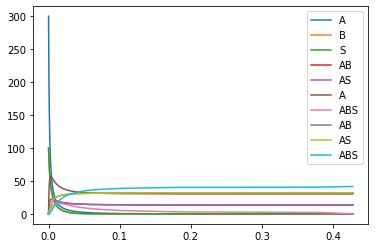

In [12]:
nodes_list = ['A','B','S','M','AB','BMS','ABS','AMS','ABMS','AM','AS']
#nodes_list = ['A','B','ABMS']
optim.plot_observable(0,nodes_list)


**After 750 optimization iterations**


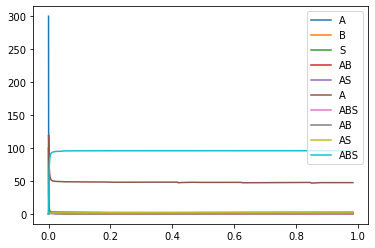

In [13]:
optim.plot_observable(-1,nodes_list)


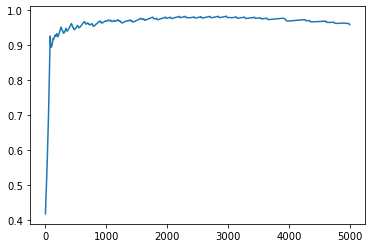

In [14]:
optim.plot_yield()

It seems like we've found a stable solution that produces greater yield than equilibrium. This should be thermodynamically
impossible. Let's try to find an explanation. We'll run simulations using the learned optimal parameters at a few different
timescales.

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3)
optim_rn = optim.rn
for i, runtime in enumerate([1, 8, 64]):
    optim_rn.reset()
    sim = VecSim(optim_rn, runtime, device='cpu')
    y = sim.simulate()
    sim.plot_observable(nodes_list,ax=ax[i],)
    ax[i].set_title("runtime: " + str(runtime) + " seconds")
fig.set_size_inches(18, 6)
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
plt.show()

In [ ]:
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

In [ ]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

In [ ]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

Clearly, the equilibrium reached by the system still matches the equilibrium solution. We have however found a set of parameters that can increase available complete AP2 at some point before equilibrium to levels significantly higher than at equilibrium. We don't observe any trapping, but have uncovered an interesting effect. 

Now we'll move on to looking at ARP23. This is 7 subunits, which drastically increases the number of possible reactions. Expect longer runtimes. 